<a href="https://colab.research.google.com/github/biodundj/abiodun_gads_project_submission/blob/master/melbourne_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Required Libraries

In [ ]:
df['user_id'] =np.where(df['post_id'].values==df2['post_id'].values,df2['user_id'],0)


In [ ]:


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import re
import missingno as msno
from scipy import stats
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.tree import DecisionTreeRegressor,plot_tree
import sklearn.metrics as mt


pd.options.display.max_rows=999
pd.options.display.max_columns=999
pd.options.display.float_format = '{:,.2f}'.format



<a id="1"></a><br>
# Load and Check Data

In [ ]:
data=pd.read_csv("/content/Melbourne_housing_FULL.csv")
data_copy=data.copy()
data_copy.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.50,"3,067.00",2.00,1.00,1.00,126.00,NaN,NaN,Yarra City Council,-37.80,145.00,Northern Metropolitan,"4,019.00"
1,Abbotsford,85 Turner St,2,h,"1,480,000.00",S,Biggin,3/12/2016,2.50,"3,067.00",2.00,1.00,1.00,202.00,NaN,NaN,Yarra City Council,-37.80,145.00,Northern Metropolitan,"4,019.00"
2,Abbotsford,25 Bloomburg St,2,h,"1,035,000.00",S,Biggin,4/02/2016,2.50,"3,067.00",2.00,1.00,0.00,156.00,79.00,"1,900.00",Yarra City Council,-37.81,144.99,Northern Metropolitan,"4,019.00"
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.50,"3,067.00",3.00,2.00,1.00,0.00,NaN,NaN,Yarra City Council,-37.81,145.01,Northern Metropolitan,"4,019.00"
4,Abbotsford,5 Charles St,3,h,"1,465,000.00",SP,Biggin,4/03/2017,2.50,"3,067.00",3.00,2.00,0.00,134.00,150.00,"1,900.00",Yarra City Council,-37.81,144.99,Northern Metropolitan,"4,019.00"


In [ ]:
def data_check(df):
    print("Data Columns: \n {}".format(df.columns))
    print("-----------------")
    print("Data Info: \n {}".format(df.info()))
    print("-----------------")
    print("Data Shape: \n {}".format(df.shape))
    print("-----------------")
    print("Data Size: \n {}".format(df.size))
    print("-----------------")
    print("Data Dimension \n {}".format(df.ndim))
    print("-----------------")
    print("Data Describe \n {}".format(df.describe().T))
    print("-----------------")
    print("Checking missing value in data: \n {}".format(df.isnull().sum()))
    print("-----------------")
    print("Checking dublicated rows in data: \n {}".format(df.duplicated().sum()))
    print("-----------------")
    print("Unique values for each features: \n {}".format(df.nunique()))

In [ ]:
data_check(data_copy)

Data Columns: 
 Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')
-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-nul

<a id="2"></a><br>
# Variable Description

1. Suburb: Suburb
1. Address: Address
1. Rooms: Number of Rooms
1. Type: House Type "br: bedroom(s)","h: house,cottage,villa, semi,terrace","u: unit, duplex","t: townhouse","dev site: development site","o res: other residential"
1. Price: Price in Australian dollars
1. Method: Sales method
1. SellerG: estate agent/Seller
1. Date: Date
1. Distance: Distance from CBD in Kilometres
1. Postcode: Postcode
1. Bedroom2: Number of bedrooms taken from different sources
1. Bathroom: Number of Bathrooms
1. Car: Number of carspots
1. Landsize: Land Size in Metres
1. BuildingArea: Building Size in Metres
1. YearBuilt: Year the house was built
1. CouncilArea: Governing council for the area
1. Lattitude: Lattitude
1. Longtitude: Longtitude
1. Regionname: General Region (West, North West, North, North east …etc)
1. Propertycount:Number of properties that exist in the suburb.

<a id="3"></a><br>
# Cleaning and Analyzing Data

In this section, we will preproces our dataset and use exploratory data analysis.

In [ ]:
data_copy.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.50,"3,067.00",2.00,1.00,1.00,126.00,NaN,NaN,Yarra City Council,-37.80,145.00,Northern Metropolitan,"4,019.00"
1,Abbotsford,85 Turner St,2,h,"1,480,000.00",S,Biggin,3/12/2016,2.50,"3,067.00",2.00,1.00,1.00,202.00,NaN,NaN,Yarra City Council,-37.80,145.00,Northern Metropolitan,"4,019.00"
2,Abbotsford,25 Bloomburg St,2,h,"1,035,000.00",S,Biggin,4/02/2016,2.50,"3,067.00",2.00,1.00,0.00,156.00,79.00,"1,900.00",Yarra City Council,-37.81,144.99,Northern Metropolitan,"4,019.00"
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.50,"3,067.00",3.00,2.00,1.00,0.00,NaN,NaN,Yarra City Council,-37.81,145.01,Northern Metropolitan,"4,019.00"
4,Abbotsford,5 Charles St,3,h,"1,465,000.00",SP,Biggin,4/03/2017,2.50,"3,067.00",3.00,2.00,0.00,134.00,150.00,"1,900.00",Yarra City Council,-37.81,144.99,Northern Metropolitan,"4,019.00"


In [ ]:
data_copy.tail()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
34852,Yarraville,13 Burns St,4,h,"1,480,000.00",PI,Jas,24/02/2018,6.30,"3,013.00",4.00,1.00,3.00,593.00,NaN,NaN,Maribyrnong City Council,-37.81,144.88,Western Metropolitan,"6,543.00"
34853,Yarraville,29A Murray St,2,h,"888,000.00",SP,Sweeney,24/02/2018,6.30,"3,013.00",2.00,2.00,1.00,98.00,104.00,"2,018.00",Maribyrnong City Council,-37.82,144.89,Western Metropolitan,"6,543.00"
34854,Yarraville,147A Severn St,2,t,"705,000.00",S,Jas,24/02/2018,6.30,"3,013.00",2.00,1.00,2.00,220.00,120.00,"2,000.00",Maribyrnong City Council,-37.82,144.88,Western Metropolitan,"6,543.00"
34855,Yarraville,12/37 Stephen St,3,h,"1,140,000.00",SP,hockingstuart,24/02/2018,6.30,"3,013.00",NaN,NaN,NaN,NaN,NaN,NaN,Maribyrnong City Council,NaN,NaN,Western Metropolitan,"6,543.00"
34856,Yarraville,3 Tarrengower St,2,h,"1,020,000.00",PI,RW,24/02/2018,6.30,"3,013.00",2.00,1.00,0.00,250.00,103.00,"1,930.00",Maribyrnong City Council,-37.82,144.89,Western Metropolitan,"6,543.00"


<a id="4"></a><br>
## Data Preprocessing

In [ ]:
# cheking dublicated rows and drop these from data set.
data_copy.loc[data_copy.duplicated(keep=False), :]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
15857,Nunawading,1/7 Lilian St,3,t,NaN,SP,Jellis,17/06/2017,15.40,"3,131.00",3.00,3.00,2.00,405.00,226.00,"2,000.00",Manningham City Council,-37.83,145.17,Eastern Metropolitan,"4,973.00"
15858,Nunawading,1/7 Lilian St,3,t,NaN,SP,Jellis,17/06/2017,15.40,"3,131.00",3.00,3.00,2.00,405.00,226.00,"2,000.00",Manningham City Council,-37.83,145.17,Eastern Metropolitan,"4,973.00"


In [ ]:
data_copy.drop_duplicates(inplace=True)
data_copy.loc[data_copy.duplicated(keep=False), :]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount


We will discard the address variable from the data set. Our dataset already includes district name and suburb name variables.

In [ ]:
data_copy.drop(["Address"],axis=1,inplace=True)

There are empty values in the price. Let's remove the rows with empty price values from the data set.

In [ ]:
data_copy.drop(data_copy[data_copy["Price"].isnull()].index,axis=0,inplace=True)
data_copy.reset_index(inplace=True)
data_copy.drop("index",axis=1,inplace=True)
data_copy.head()

,Suburb,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,2,h,"1,480,000.00",S,Biggin,3/12/2016,2.50,"3,067.00",2.00,1.00,1.00,202.00,NaN,NaN,Yarra City Council,-37.80,145.00,Northern Metropolitan,"4,019.00"
1,Abbotsford,2,h,"1,035,000.00",S,Biggin,4/02/2016,2.50,"3,067.00",2.00,1.00,0.00,156.00,79.00,"1,900.00",Yarra City Council,-37.81,144.99,Northern Metropolitan,"4,019.00"
2,Abbotsford,3,h,"1,465,000.00",SP,Biggin,4/03/2017,2.50,"3,067.00",3.00,2.00,0.00,134.00,150.00,"1,900.00",Yarra City Council,-37.81,144.99,Northern Metropolitan,"4,019.00"
3,Abbotsford,3,h,"850,000.00",PI,Biggin,4/03/2017,2.50,"3,067.00",3.00,2.00,1.00,94.00,NaN,NaN,Yarra City Council,-37.80,145.00,Northern Metropolitan,"4,019.00"
4,Abbotsford,4,h,"1,600,000.00",VB,Nelson,4/06/2016,2.50,"3,067.00",3.00,1.00,2.00,120.00,142.00,"2,014.00",Yarra City Council,-37.81,144.99,Northern Metropolitan,"4,019.00"


In [ ]:
# check missing values
data_copy.isnull().sum()

Suburb               0
Rooms                0
Type                 0
Price                0
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          6441
Bathroom          6447
Car               6824
Landsize          9265
BuildingArea     16591
YearBuilt        15163
CouncilArea          3
Lattitude         6254
Longtitude        6254
Regionname           3
Propertycount        3
dtype: int64

<a id="5"></a><br>
### Variable Types

Let's determine categorical and numerical variables.

* Categorical variables: "Suburb", "Type", "Method", "SellerG", "Postcode", "CouncilArea", "Regionname"
* Numerical variables: "Rooms", "Price", "Distance", Bedroom2", "Bathroom", "Car", "Landsize", "BuildingArea", "YearBuild", "Lattitude", "Longtitude", "Propertycount"

In [ ]:
object_columns=list(data_copy.select_dtypes("object").columns)

print(object_columns)

['Suburb', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']


In [ ]:
object_columns.remove("Date")
print(object_columns)

['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']


In [ ]:
# Postcode will transform to the object data type.
data_copy["Postcode"]=data_copy["Postcode"].astype("object")
object_columns.append("Postcode")

We will later change the data types of categorical variables to categorical in order to make visualizations better.

In [ ]:
numeric_columns=list(data_copy.select_dtypes(["float64","int64"]).columns)
numeric_columns

['Rooms',
 'Price',
 'Distance',
 'Bedroom2',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'Lattitude',
 'Longtitude',
 'Propertycount']

<a id="6"></a><br>
### Missing Values

First we will check the randomness of missing values.

In [ ]:
data_copy.isnull().sum()

Suburb               0
Rooms                0
Type                 0
Price                0
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          6441
Bathroom          6447
Car               6824
Landsize          9265
BuildingArea     16591
YearBuilt        15163
CouncilArea          3
Lattitude         6254
Longtitude        6254
Regionname           3
Propertycount        3
dtype: int64

<Figure size 1000x800 with 0 Axes>

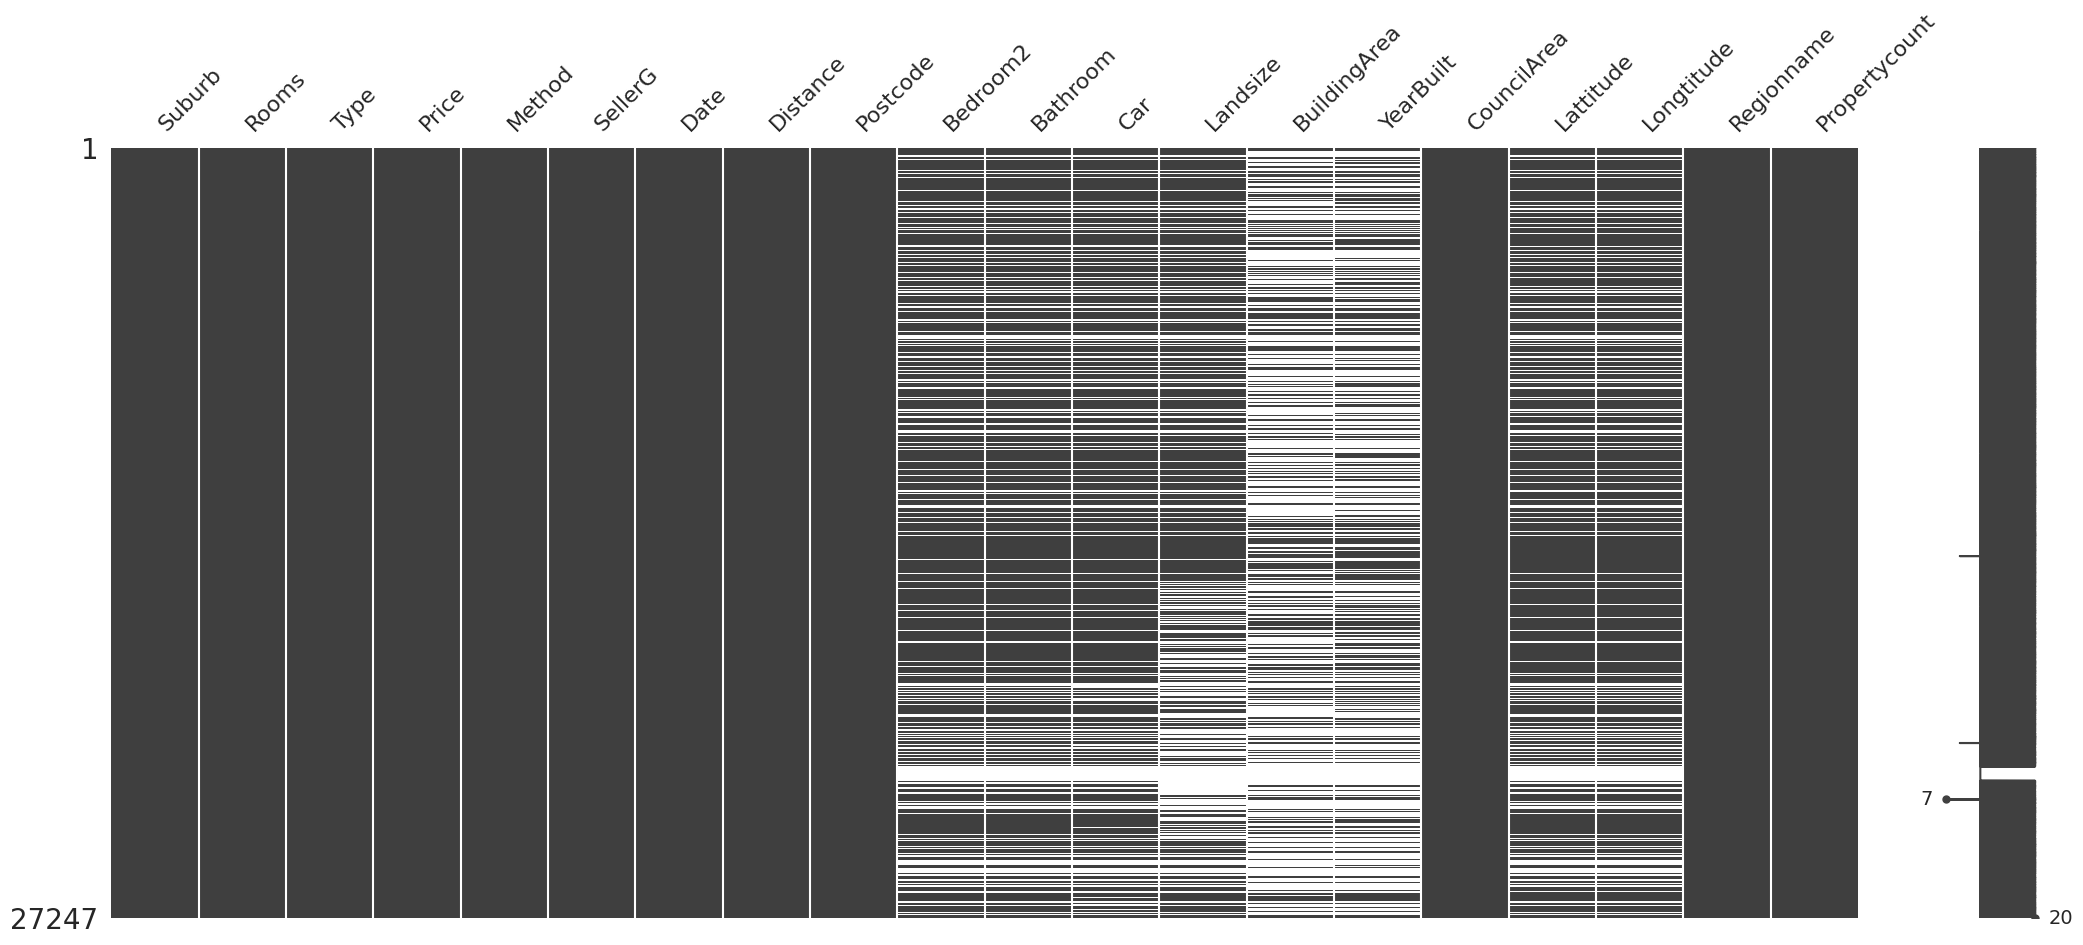

In [ ]:
# visualization of missing observations
plt.figure(figsize=(10,8))
msno.matrix(data_copy)
plt.show()

<Figure size 800x600 with 0 Axes>

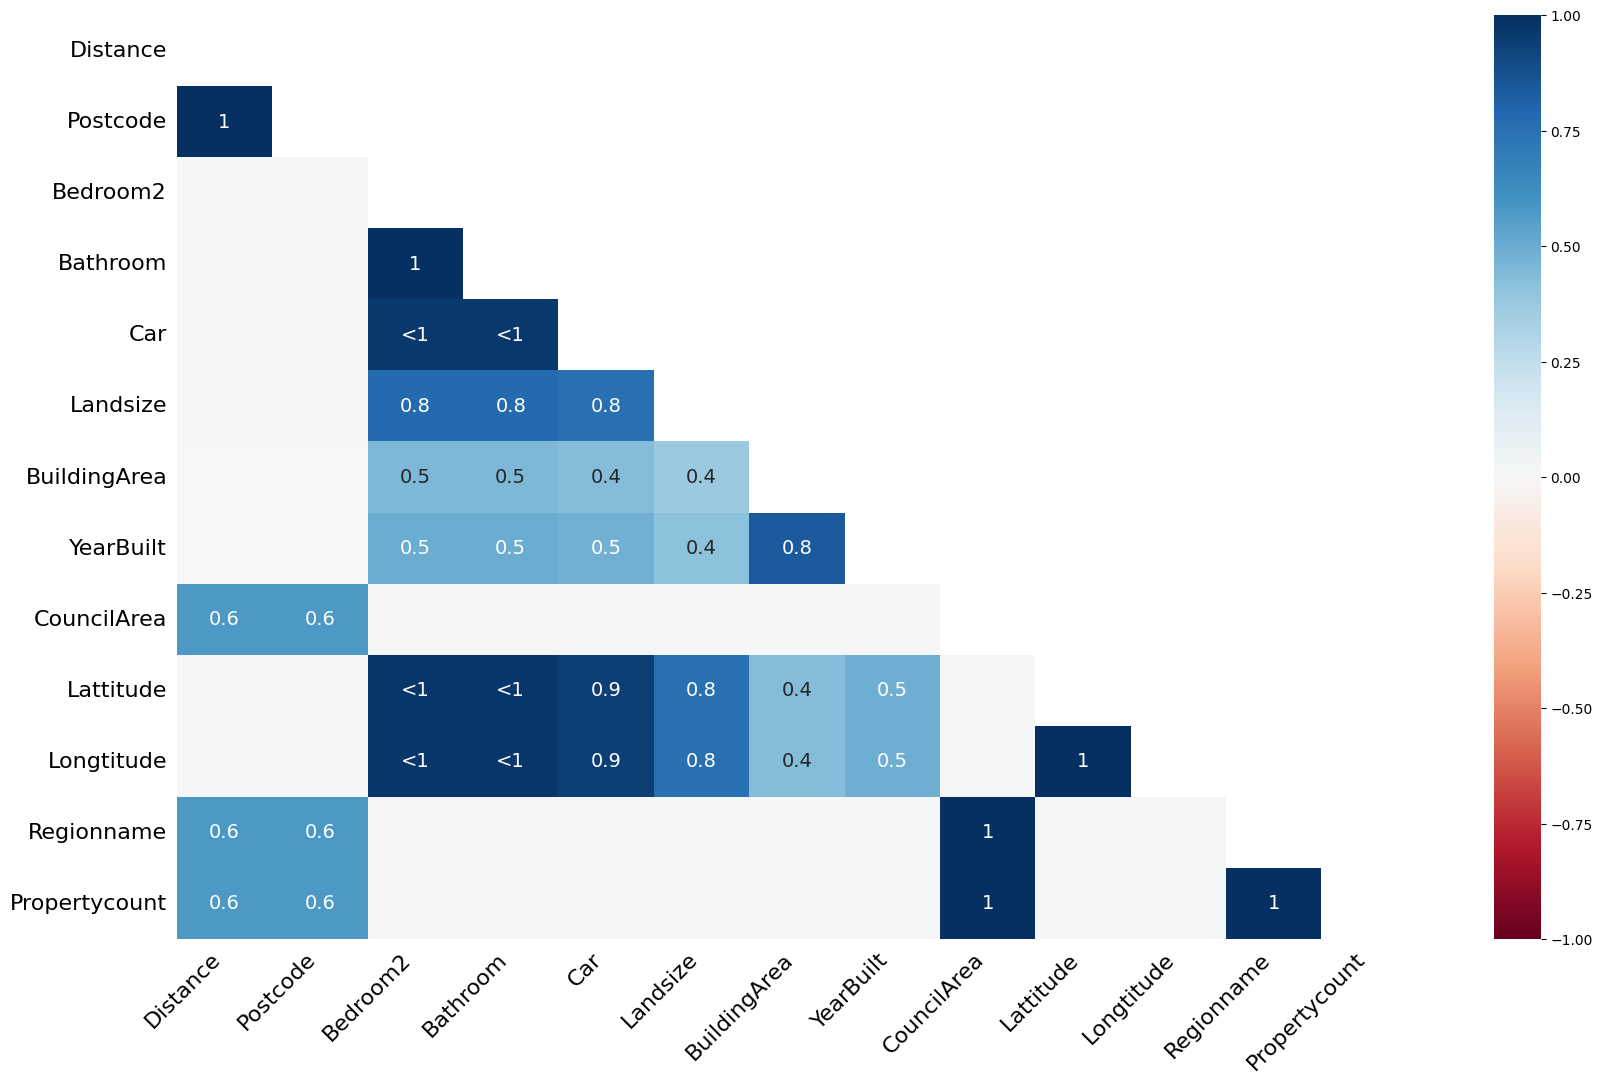

In [ ]:
plt.figure(figsize=(8,6))
msno.heatmap(data_copy)
plt.show()

In [ ]:
# checking bedroom2 variable because this data was taken from different source.
data_copy["Rooms_Bedroom2"]=data_copy["Rooms"]-data_copy["Bedroom2"]
data_copy[data_copy["Rooms_Bedroom2"]<0].head()

,Suburb,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Rooms_Bedroom2
6,Abbotsford,3,h,"1,876,000.00",S,Nelson,7/05/2016,2.50,"3,067.00",4.00,2.00,0.00,245.00,210.00,"1,910.00",Yarra City Council,-37.80,145.00,Northern Metropolitan,"4,019.00",-1.00
11,Abbotsford,2,h,"1,097,000.00",S,Biggin,8/10/2016,2.50,"3,067.00",3.00,1.00,2.00,220.00,75.00,"1,900.00",Yarra City Council,-37.80,145.00,Northern Metropolitan,"4,019.00",-1.00
91,Airport West,4,h,"773,000.00",S,Brad,17/09/2016,13.50,"3,042.00",5.00,3.00,4.00,531.00,309.00,"1,980.00",Moonee Valley City Council,-37.73,144.87,Western Metropolitan,"3,464.00",-1.00
290,Altona North,3,h,"620,000.00",SP,Hunter,22/08/2016,11.10,"3,025.00",5.00,2.00,2.00,276.00,100.00,"2,010.00",Hobsons Bay City Council,-37.83,144.84,Western Metropolitan,"5,132.00",-2.00
327,Armadale,2,u,"3,625,000.00",S,Jellis,4/06/2016,6.30,"3,143.00",3.00,2.00,2.00,0.00,NaN,"2,006.00",Stonnington City Council,-37.86,145.03,Southern Metropolitan,"4,836.00",-1.00


In [ ]:
# rooms_bedroom2 variable that we created includes negative values. We think this variable is an incorretly variable.
data_copy.drop(["Bedroom2","Rooms_Bedroom2"],axis=1,inplace=True)

<Figure size 800x600 with 0 Axes>

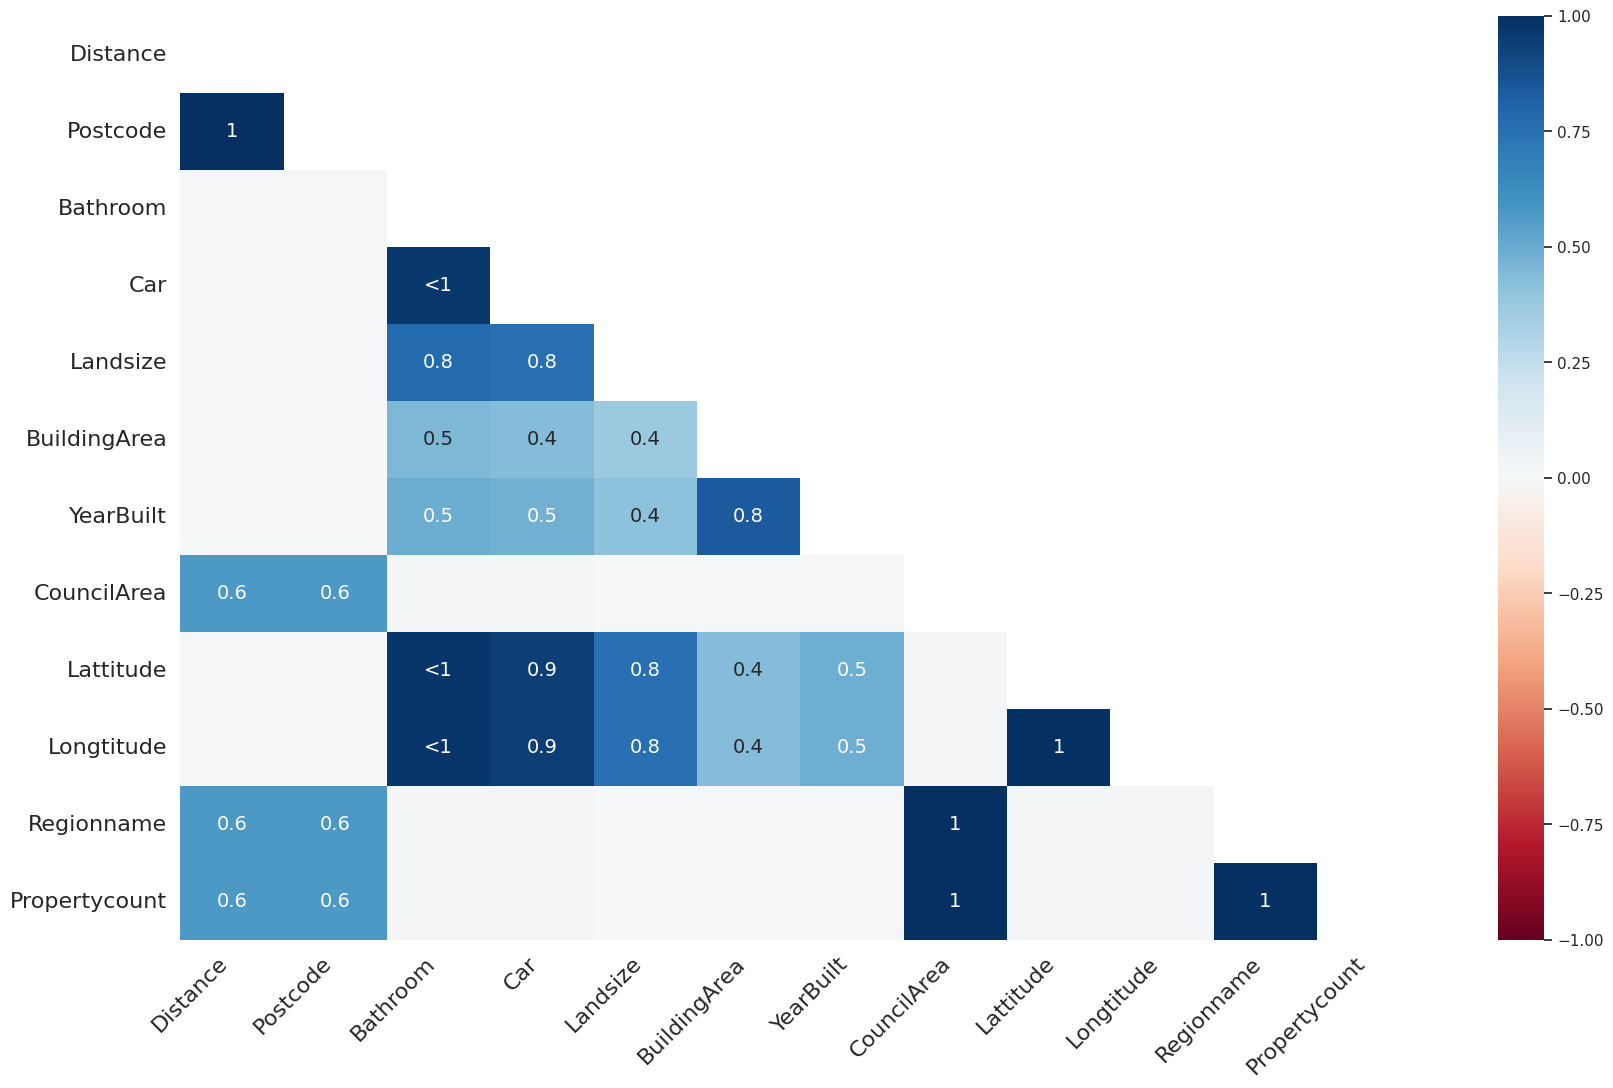

In [ ]:
plt.figure(figsize=(8,6))
msno.heatmap(data_copy)
plt.show()

In [ ]:
# Missing values of variables with correlations above 0.8 did not occur randomly.
data_copy.drop(data_copy[data_copy["Postcode"].isnull()].index,axis=0,inplace=True)
data_copy.drop(data_copy[data_copy["Car"].isnull()].index,axis=0,inplace=True)

<Figure size 800x600 with 0 Axes>

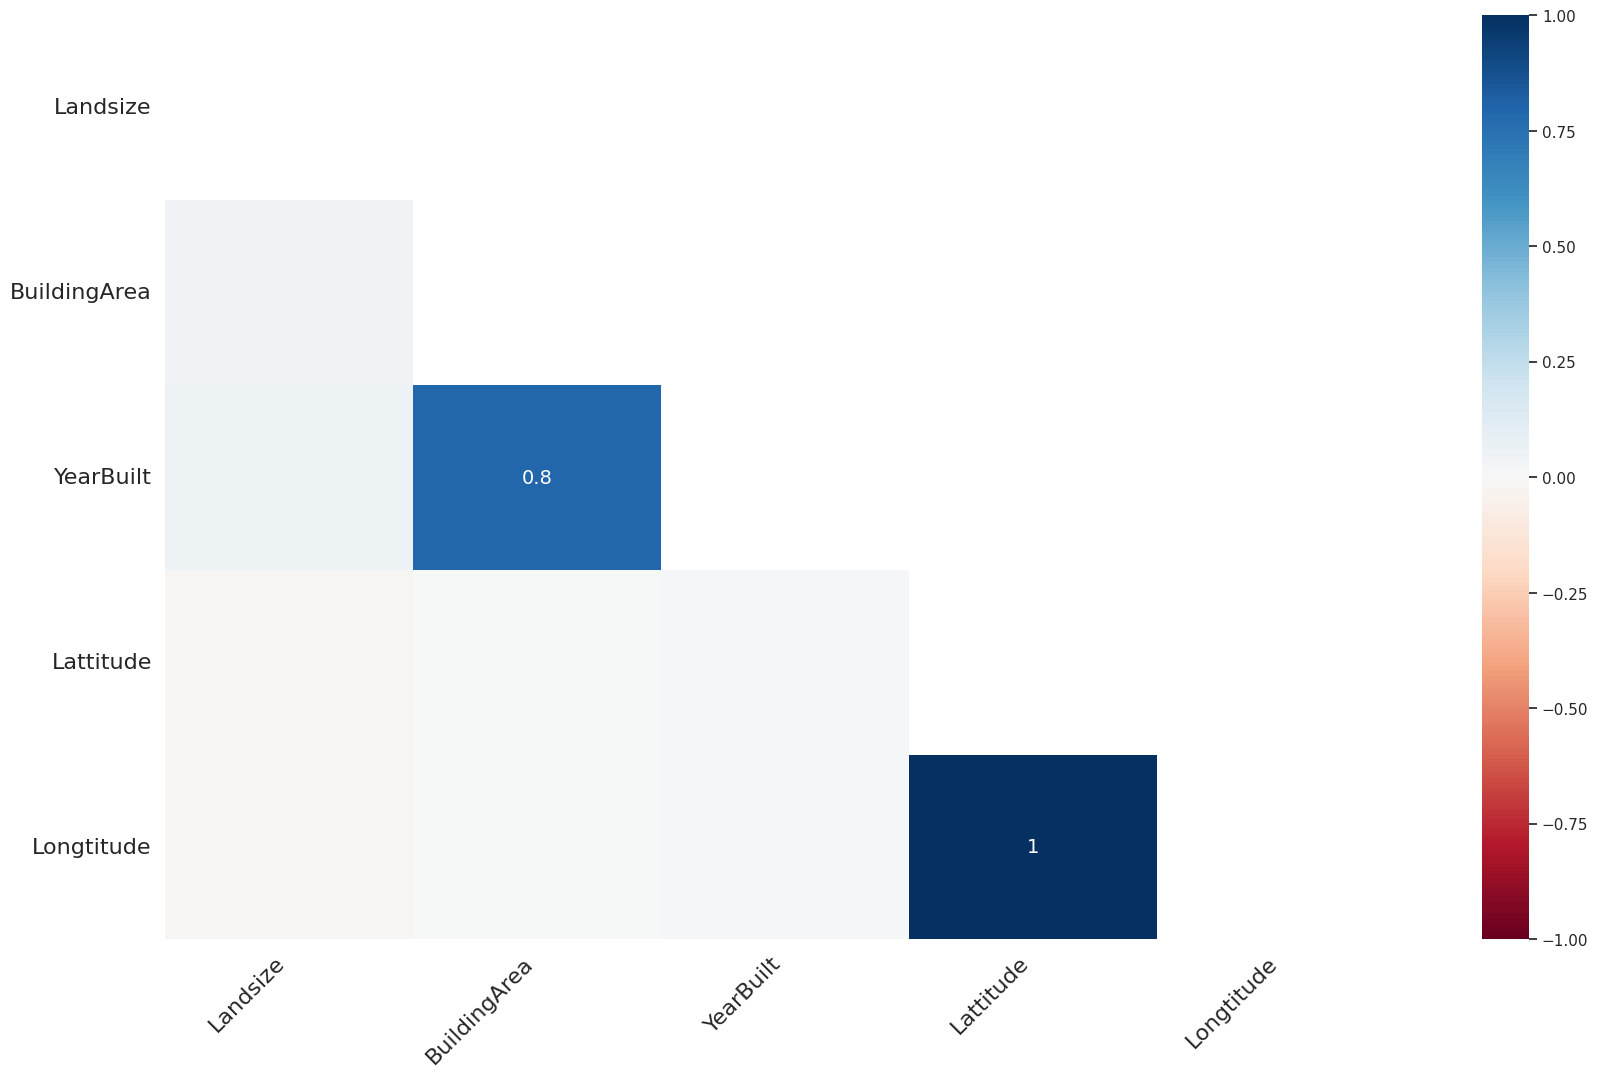

In [ ]:
plt.figure(figsize=(8,6))
msno.heatmap(data_copy)
plt.show()

In [ ]:
data_copy.drop(data_copy[data_copy["Lattitude"].isnull()].index,axis=0,inplace=True)
data_copy.isnull().sum()

Suburb              0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bathroom            0
Car                 0
Landsize         2722
BuildingArea     9931
YearBuilt        8521
CouncilArea         0
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [ ]:
# Building age calculation
data_copy["Building_Age"]=2023 -data_copy['YearBuilt']
# Drop YearBuilt variable
data_copy.drop("YearBuilt",axis=1,inplace=True)

data_copy["Building_Age"].describe().T

count   11,880.00
mean        55.70
std         36.29
min          4.00
25%         23.00
50%         53.00
75%         73.00
max        827.00
Name: Building_Age, dtype: float64

In [ ]:
data_copy.describe()

,Rooms,Price,Distance,Bathroom,Car,Landsize,BuildingArea,Lattitude,Longtitude,Propertycount,Building_Age
count,"20,401.00","20,401.00","20,401.00","20,401.00","20,401.00","17,679.00","10,470.00","20,401.00","20,401.00","20,401.00","11,880.00"
mean,3.07,"1,088,338.74",11.44,1.60,1.72,594.87,157.41,-37.81,145.00,"7,508.85",55.70
std,0.95,"655,256.64",6.87,0.70,0.99,"3,786.38",453.11,0.09,0.12,"4,411.86",36.29
min,1.00,"85,000.00",0.00,0.00,0.00,0.00,0.00,-38.19,144.42,83.00,4.00
25%,2.00,"655,000.00",6.60,1.00,1.00,222.50,100.00,-37.86,144.92,"4,380.00",23.00
50%,3.00,"905,000.00",10.50,1.00,2.00,517.00,133.00,-37.80,145.00,"6,567.00",53.00
75%,4.00,"1,330,000.00",14.20,2.00,2.00,664.00,183.00,-37.75,145.07,"10,331.00",73.00
max,16.00,"11,200,000.00",48.10,9.00,18.00,"433,014.00","44,515.00",-37.40,145.53,"21,650.00",827.00


In [ ]:
# Landsize and Build Area cannot be 0 or negative. Convert them to nan
data_copy.loc[data_copy["Landsize"] <= 0, "Landsize"] = np.nan
data_copy.loc[data_copy["BuildingArea"] <= 0, "BuildingArea"] = np.nan

Let's examine how we can fill empty values in the land size variable.

In [ ]:
data_copy[["Type","Rooms","Car","Landsize"]].groupby(["Type"]).mean().sort_values(by="Landsize",ascending=False)

,Rooms,Car,Landsize
Type,,,
u,1.98,1.14,"1,028.81"
h,3.33,1.86,659.85
t,2.87,1.60,320.87


In [ ]:
data_copy[["Type","Rooms","Car","Landsize"]].groupby(["Type","Rooms","Car"]).mean().sort_values(by="Landsize",ascending=False).head()

Landsize
Type Rooms Car           
h    4     8.00  7,989.14
     5     5.00  3,821.53
     8     4.00  2,361.67
u    3     3.00  2,242.00
h    7     4.00  2,162.60

In [ ]:
data_copy[["Type","Car","Landsize"]].groupby(["Type","Car"]).mean().sort_values(by="Landsize",ascending=False)

Landsize
Type Car            
h    8.00   4,959.75
u    2.00   1,341.79
h    18.00  1,250.00
u    0.00   1,217.06
h    5.00   1,206.20
u    1.00     936.38
h    10.00    927.25
     6.00     867.53
     4.00     806.95
u    3.00     794.94
h    7.00     764.21
u    4.00     761.25
h    3.00     746.18
     9.00     721.00
     11.00    697.00
     2.00     662.47
     1.00     637.23
u    7.00     420.00
t    3.00     418.58
     4.00     407.60
h    0.00     389.18
t    0.00     359.29
u    6.00     335.00
t    2.00     330.68
     1.00     300.40
     5.00        NaN

In [ ]:
# Filling missing data in Landsize
data_copy["Landsize"].fillna(value=data_copy[["Type","Car","Landsize"]].groupby(["Type","Car"])["Landsize"].transform("mean"),inplace=True)

In [ ]:
data_copy.isnull().sum()

Suburb              0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bathroom            0
Car                 0
Landsize            1
BuildingArea     9990
CouncilArea         0
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
Building_Age     8521
dtype: int64

In [ ]:
data_copy.drop(data_copy[data_copy["Landsize"].isnull()].index,axis=0,inplace=True)

Let's examine how we can fill empty values in the bulding area variable.

In [ ]:
data_copy[["Type","Rooms","Car","BuildingArea"]].groupby(["Type","Rooms"]).mean().sort_values(by="BuildingArea",ascending=False)

Car  BuildingArea
Type Rooms                   
h    10    2.00        466.00
     5     2.36        364.19
     7     2.64        341.79
     6     2.61        294.03
t    4     1.87        258.76
h    8     3.44        256.00
     12    3.00        223.00
     4     2.11        208.02
t    5     1.80        159.67
h    3     1.77        141.05
t    3     1.69        139.33
u    4     2.20        135.00
t    2     1.23        119.33
u    3     1.50        117.17
h    2     1.19        103.45
     1     0.75         92.23
u    2     1.15         84.68
t    1     0.67         77.50
u    1     0.91         50.19
     8     4.00           NaN

In [ ]:
# Filling missing data in BuildingArea
data_copy["BuildingArea"].fillna(value=data_copy[["Type","Rooms","BuildingArea"]].groupby(["Type","Rooms"])["BuildingArea"].transform("mean"),inplace=True)
data_copy.isnull().sum()

Suburb              0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bathroom            0
Car                 0
Landsize            0
BuildingArea        1
CouncilArea         0
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
Building_Age     6569
dtype: int64

In [ ]:
data_copy.drop(data_copy[data_copy["BuildingArea"].isnull()].index,axis=0,inplace=True)

Let's examine how we can fill empty values in the building age variable.

In [ ]:
data_copy[["Suburb","Building_Age"]].groupby(["Suburb"]).mean().sort_values(by="Building_Age",ascending=False).head()

,Building_Age
Suburb,
Princes Hill,126.33
Albert Park,120.88
Middle Park,119.50
South Melbourne,112.79
Carlton,106.31


In [ ]:
# Filling missing data in Building_Age
data_copy["Building_Age"].fillna(value=round(data_copy[["Suburb","Building_Age"]].groupby(["Suburb"])["Building_Age"].transform("mean"),1),inplace=True)
data_copy.isnull().sum()

Suburb            0
Rooms             0
Type              0
Price             0
Method            0
SellerG           0
Date              0
Distance          0
Postcode          0
Bathroom          0
Car               0
Landsize          0
BuildingArea      0
CouncilArea       0
Lattitude         0
Longtitude        0
Regionname        0
Propertycount     0
Building_Age     22
dtype: int64

In [ ]:
data_copy[["Regionname","Building_Age"]].groupby(["Regionname"]).mean().sort_values(by="Building_Age",ascending=False)

,Building_Age
Regionname,
Southern Metropolitan,66.83
Northern Metropolitan,61.75
Western Metropolitan,53.83
Eastern Metropolitan,50.67
South-Eastern Metropolitan,47.00
Western Victoria,42.96
Eastern Victoria,36.73
Northern Victoria,30.21


In [ ]:
data_copy.drop(data_copy[data_copy["Building_Age"].isnull()].index,axis=0,inplace=True)
data_copy.isnull().sum()

Suburb           0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
Building_Age     0
dtype: int64

In [ ]:
data_copy.reset_index(inplace=True)
data_copy.drop("index",axis=1,inplace=True)

<a id="7"></a><br>
### Feature Engineering

* We will edit the categorical group names of the Suburb and SallerG variables
* We will create new features that are month, year and season.
* We will check if there is incorrectly entered data.
* We will try to create new features from available features.

In [ ]:
def word_edit(df,variable):
    clear=[]

    for i in range(len(df)):
        edit=re.sub("[^a-zA-z/s]","",df[variable][i]) # removing characters other than letters and spaces
        edit=edit.lower()
        edit=edit.split()[0] # taking first word
        clear.append(edit)

    return clear

seller=word_edit(data_copy,"SellerG")
data_copy["SellerG"]=seller

In [ ]:
def word_edit2(df,variable):
    clear=[]

    for i in range(len(df)):
        edit=re.sub("[^a-zA-z/s]","",df[variable][i]) # removing characters other than letters and spaces
        edit=edit.lower()
        clear.append(edit)

    return clear

suburb=word_edit2(data_copy,"Suburb")
data_copy["Suburb"]=suburb

In [ ]:
# We will create years, months and seasons through the date variable.
year=[i.split("/")[2] for i in data_copy.Date]
month=[i.split("/")[1] for i in data_copy.Date]
data_copy["Year"]=year
data_copy["Month"]=month

data_copy["Month"]=data_copy["Month"].astype("object")
for i in data_copy.index.values:
    if data_copy.loc[i,"Month"]=="01":
        data_copy.loc[i,"Month"]="January"
    elif data_copy.loc[i,"Month"]=="02":
        data_copy.loc[i,"Month"]="February"
    elif data_copy.loc[i,"Month"]=="03":
        data_copy.loc[i,"Month"]="March"
    elif data_copy.loc[i,"Month"]=="04":
        data_copy.loc[i,"Month"]="April"
    elif data_copy.loc[i,"Month"]=="05":
        data_copy.loc[i,"Month"]="May"
    elif data_copy.loc[i,"Month"]=="06":
        data_copy.loc[i,"Month"]="June"
    elif data_copy.loc[i,"Month"]=="07":
        data_copy.loc[i,"Month"]="July"
    elif data_copy.loc[i,"Month"]=="08":
        data_copy.loc[i,"Month"]="August"
    elif data_copy.loc[i,"Month"]=="09":
        data_copy.loc[i,"Month"]="September"
    elif data_copy.loc[i,"Month"]=="10":
        data_copy.loc[i,"Month"]="October"
    elif data_copy.loc[i,"Month"]=="11":
        data_copy.loc[i,"Month"]="November"
    else:
        data_copy.loc[i,"Month"]="December"


data_copy["Seasonal"]=np.where(data_copy["Month"].isin(["March","April","May"]),"spring",
                np.where(data_copy["Month"].isin(["June","July","August"]),"summer",
                         np.where(data_copy["Month"].isin(["September","October","November"]),"fall",
                                  np.where(data_copy["Month"].isin(["December","January","February"]),"winter","None"))))

# dropping date variable
data_copy.drop("Date",axis=1,inplace=True)

In [ ]:
# checking incorretly data
data_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,"15,717.00",3.19,0.88,1.00,3.00,3.00,4.00,12.00
Price,"15,717.00","1,150,884.26","663,228.56","131,000.00","710,000.00","965,000.00","1,400,000.00","11,200,000.00"
Distance,"15,717.00",11.72,6.67,0.00,7.30,10.80,14.30,47.40
Bathroom,"15,717.00",1.63,0.71,0.00,1.00,2.00,2.00,9.00
Car,"15,717.00",1.77,1.02,0.00,1.00,2.00,2.00,18.00
Landsize,"15,717.00",649.71,"3,860.66",1.00,307.00,555.00,685.00,"433,014.00"
BuildingArea,"15,717.00",160.29,109.08,1.00,115.00,141.05,199.00,"6,791.00"
Lattitude,"15,717.00",-37.80,0.09,-38.19,-37.86,-37.80,-37.74,-37.40
Longtitude,"15,717.00",145.00,0.12,144.42,144.92,145.01,145.07,145.53
Propertycount,"15,717.00","7,394.15","4,415.26",249.00,"4,217.00","6,482.00","10,331.00","21,650.00"


In [ ]:
# Categorical groups of building age:
data_copy["Building_Age_Group"]=["new" if each <6 else "normal" if (each>5 and each<26) else "old"
                                 if (each>25 and each<50) else "historical" for each in data_copy["Building_Age"]]
data_copy.head()

,Suburb,Rooms,Type,Price,Method,SellerG,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Building_Age,Year,Month,Seasonal,Building_Age_Group
0,abbotsford,2,h,"1,480,000.00",S,biggin,2.50,"3,067.00",1.00,1.00,202.00,103.45,Yarra City Council,-37.80,145.00,Northern Metropolitan,"4,019.00",89.20,2016,December,winter,historical
1,abbotsford,2,h,"1,035,000.00",S,biggin,2.50,"3,067.00",1.00,0.00,156.00,79.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,"4,019.00",123.00,2016,February,winter,historical
2,abbotsford,3,h,"1,465,000.00",SP,biggin,2.50,"3,067.00",2.00,0.00,134.00,150.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,"4,019.00",123.00,2017,March,spring,historical
3,abbotsford,3,h,"850,000.00",PI,biggin,2.50,"3,067.00",2.00,1.00,94.00,141.05,Yarra City Council,-37.80,145.00,Northern Metropolitan,"4,019.00",89.20,2017,March,spring,historical
4,abbotsford,4,h,"1,600,000.00",VB,nelson,2.50,"3,067.00",1.00,2.00,120.00,142.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,"4,019.00",9.00,2016,June,summer,normal


In [ ]:
# we will categorize Suburb size according Propertycount
data_copy["suburb_size"]=["extra small" if each<501 else "small" if (each>500 and each<2001) else "normal"
                           if (each>2000 and each<10001) else "high" if (each>10000 and each<15001) else "extra high" for each in data_copy["Propertycount"]]
data_copy.head()

,Suburb,Rooms,Type,Price,Method,SellerG,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Building_Age,Year,Month,Seasonal,Building_Age_Group,suburb_size
0,abbotsford,2,h,"1,480,000.00",S,biggin,2.50,"3,067.00",1.00,1.00,202.00,103.45,Yarra City Council,-37.80,145.00,Northern Metropolitan,"4,019.00",89.20,2016,December,winter,historical,normal
1,abbotsford,2,h,"1,035,000.00",S,biggin,2.50,"3,067.00",1.00,0.00,156.00,79.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,"4,019.00",123.00,2016,February,winter,historical,normal
2,abbotsford,3,h,"1,465,000.00",SP,biggin,2.50,"3,067.00",2.00,0.00,134.00,150.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,"4,019.00",123.00,2017,March,spring,historical,normal
3,abbotsford,3,h,"850,000.00",PI,biggin,2.50,"3,067.00",2.00,1.00,94.00,141.05,Yarra City Council,-37.80,145.00,Northern Metropolitan,"4,019.00",89.20,2017,March,spring,historical,normal
4,abbotsford,4,h,"1,600,000.00",VB,nelson,2.50,"3,067.00",1.00,2.00,120.00,142.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,"4,019.00",9.00,2016,June,summer,normal,normal


In [ ]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15717 entries, 0 to 15716
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Suburb              15717 non-null  object 
 1   Rooms               15717 non-null  int64  
 2   Type                15717 non-null  object 
 3   Price               15717 non-null  float64
 4   Method              15717 non-null  object 
 5   SellerG             15717 non-null  object 
 6   Distance            15717 non-null  float64
 7   Postcode            15717 non-null  object 
 8   Bathroom            15717 non-null  float64
 9   Car                 15717 non-null  float64
 10  Landsize            15717 non-null  float64
 11  BuildingArea        15717 non-null  float64
 12  CouncilArea         15717 non-null  object 
 13  Lattitude           15717 non-null  float64
 14  Longtitude          15717 non-null  float64
 15  Regionname          15717 non-null  object 
 16  Prop

In [ ]:
numeric_columns.extend(["Building_Age"])
object_columns.extend(["Year","Month","Seasonal","Building_Age_Group","suburb_size"])

In [ ]:
data_copy["Postcode"]=data_copy["Postcode"].astype(int)
data_copy["Bathroom"]=data_copy["Bathroom"].astype(int)
data_copy["Car"]=data_copy["Car"].astype(int)
data_copy["Building_Age"]=data_copy["Building_Age"].astype(int)
data_copy["Propertycount"]=data_copy["Propertycount"].astype(int)

In [ ]:
data_copy["Postcode"]=data_copy["Postcode"].astype("object")

In [ ]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15717 entries, 0 to 15716
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Suburb              15717 non-null  object 
 1   Rooms               15717 non-null  int64  
 2   Type                15717 non-null  object 
 3   Price               15717 non-null  float64
 4   Method              15717 non-null  object 
 5   SellerG             15717 non-null  object 
 6   Distance            15717 non-null  float64
 7   Postcode            15717 non-null  object 
 8   Bathroom            15717 non-null  int64  
 9   Car                 15717 non-null  int64  
 10  Landsize            15717 non-null  float64
 11  BuildingArea        15717 non-null  float64
 12  CouncilArea         15717 non-null  object 
 13  Lattitude           15717 non-null  float64
 14  Longtitude          15717 non-null  float64
 15  Regionname          15717 non-null  object 
 16  Prop

<a id="8"></a><br>
### Outlier Detection

* We will detect outliers with z-score method in numerical variable.

In [ ]:
# Determining the number of groups less than 15 as categorical variables
for i in ["Rooms","Distance","Bathroom","Car","Propertycount"]:
    print("***** {} value counts ********".format(i))
    print(data_copy[i].value_counts())

***** Rooms value counts ********
3     7646
4     4056
2     2784
5      870
1      242
6       93
7       14
8        9
10       2
12       1
Name: Rooms, dtype: int64
***** Distance value counts ********
11.20    737
9.20     338
13.80    314
10.50    311
13.90    308
14.70    296
8.40     286
7.80     280
5.20     263
8.80     232
13.00    231
11.40    226
9.70     219
7.50     213
6.40     210
14.00    197
8.00     195
12.40    185
17.90    185
20.60    175
7.00     172
2.60     171
12.10    170
5.90     169
12.00    166
15.50    163
4.60     162
6.20     160
16.70    160
5.30     154
11.70    153
18.00    146
10.40    143
7.70     137
31.70    133
3.50     128
18.40    124
8.20     122
9.90     121
6.30     120
10.20    118
11.80    118
7.90     118
5.50     117
16.10    117
6.70     117
8.50     113
3.30     112
7.30     110
13.10    110
13.50    106
19.60    104
10.70    104
4.30     103
9.40     100
14.50    100
14.30     97
4.50      96
6.90      95
17.20     95
5.60      94


In [ ]:
data_copy["Rooms"]=data_copy["Rooms"].astype("object")
data_copy["Bathroom"]=data_copy["Bathroom"].astype("object")
data_copy["Car"]=data_copy["Car"].astype("object")

In [ ]:
num_var=data_copy.select_dtypes(include=["float64","int64"])
num_var

,Price,Distance,Landsize,BuildingArea,Lattitude,Longtitude,Propertycount,Building_Age
0,"1,480,000.00",2.50,202.00,103.45,-37.80,145.00,4019,89
1,"1,035,000.00",2.50,156.00,79.00,-37.81,144.99,4019,123
2,"1,465,000.00",2.50,134.00,150.00,-37.81,144.99,4019,123
3,"850,000.00",2.50,94.00,141.05,-37.80,145.00,4019,89
4,"1,600,000.00",2.50,120.00,142.00,-37.81,144.99,4019,9
...,...,...,...,...,...,...,...,...
15712,"570,000.00",25.50,404.00,158.00,-37.61,145.03,2940,11
15713,"1,480,000.00",6.30,593.00,208.02,-37.81,144.88,6543,76
15714,"888,000.00",6.30,98.00,104.00,-37.82,144.89,6543,5
15715,"705,000.00",6.30,220.00,120.00,-37.82,144.88,6543,23


In [ ]:
num_var.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,"15,717.00","1,150,884.26","663,228.56","131,000.00","710,000.00","965,000.00","1,400,000.00","11,200,000.00"
Distance,"15,717.00",11.72,6.67,0.00,7.30,10.80,14.30,47.40
Landsize,"15,717.00",649.71,"3,860.66",1.00,307.00,555.00,685.00,"433,014.00"
BuildingArea,"15,717.00",160.29,109.08,1.00,115.00,141.05,199.00,"6,791.00"
Lattitude,"15,717.00",-37.80,0.09,-38.19,-37.86,-37.80,-37.74,-37.40
Longtitude,"15,717.00",145.00,0.12,144.42,144.92,145.01,145.07,145.53
Propertycount,"15,717.00","7,394.15","4,415.26",249.00,"4,217.00","6,482.00","10,331.00","21,650.00"
Building_Age,"15,717.00",58.55,31.05,4.00,39.00,53.00,73.00,827.00


When we examine the summary statistics, we see that there may be outliers in price, distance, landsize, buildingarea, propertycount and building age variables.

In [ ]:
# Numeric
def plot_hist(data,variable):
    """
        input: variable ex: "price"
        output: hist plot
    """
    plt.figure(figsize=(9,3))
    plt.hist(data[variable],bins=30)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title(f"{variable} distribution with hist")
    plt.show()

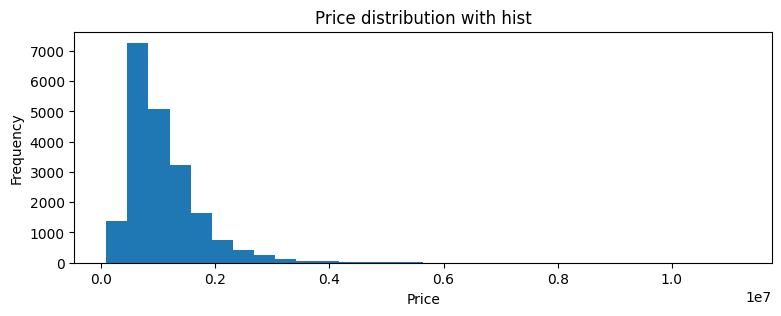

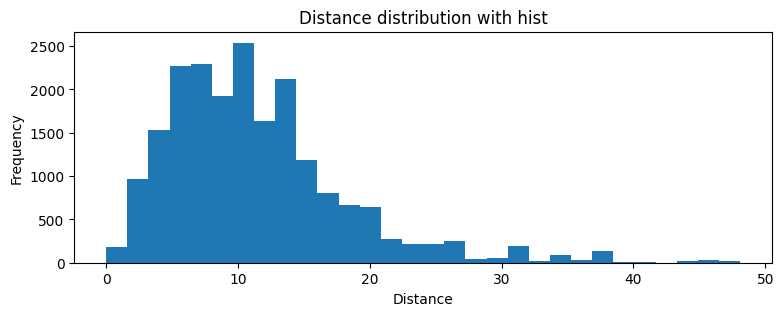

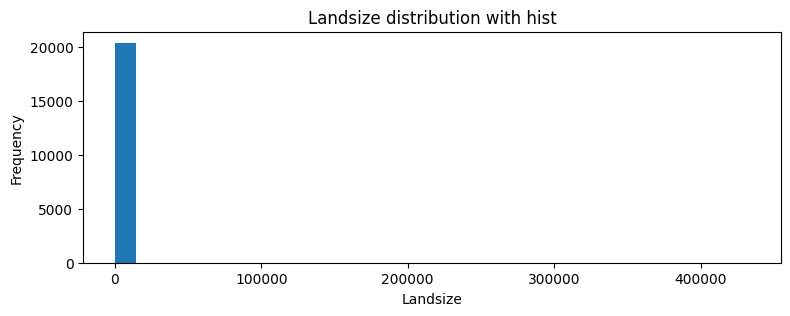

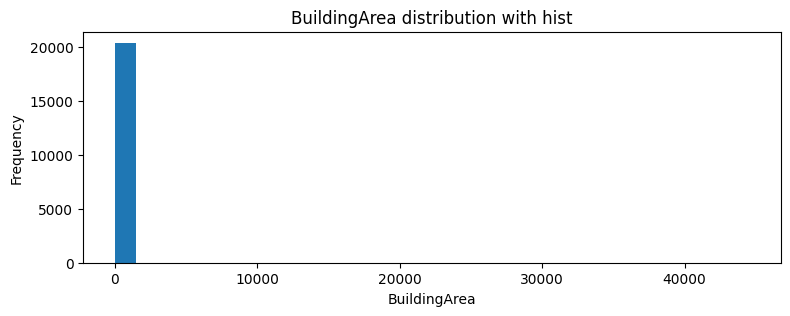

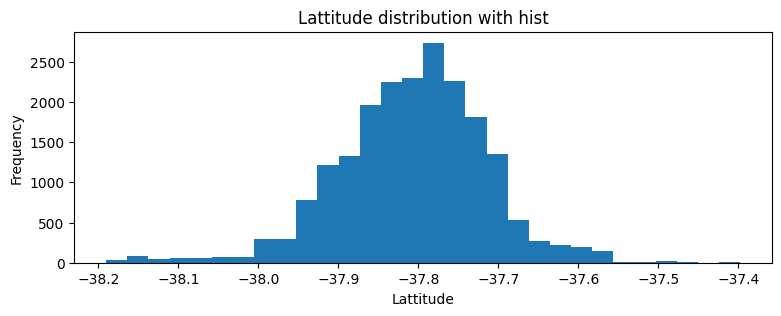

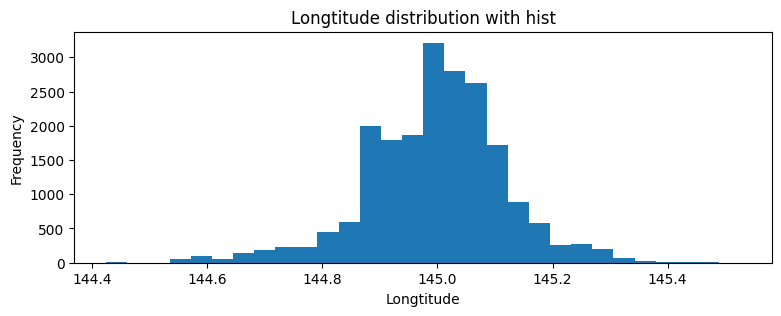

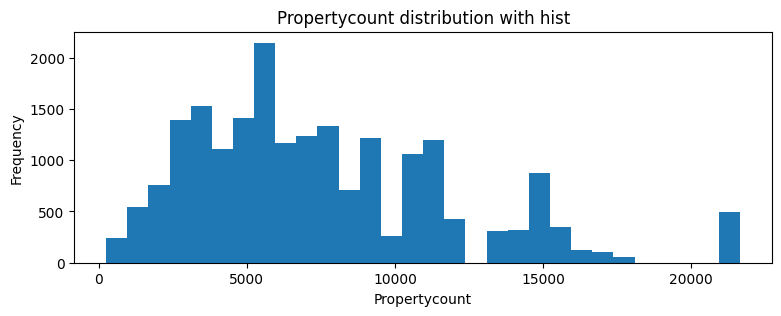

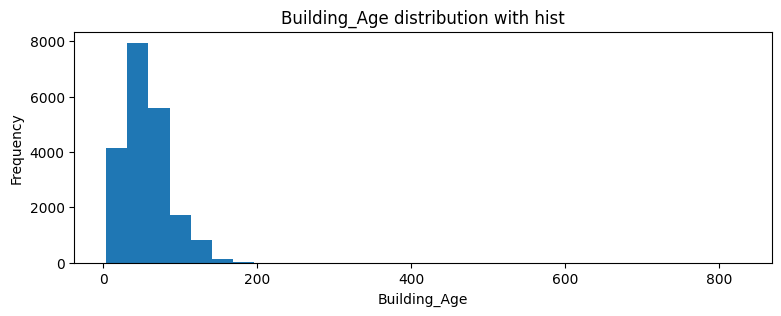

In [ ]:
for i in list(num_var.columns):
    plot_hist(data_copy,i)

In [ ]:
## detecting outlier with z-score method and filling it with mean

for i in list(num_var.columns):

    max_value=(3*data_copy[i].std())+data_copy[i].mean() # finds the max value that is not going to be called not an outlier
    min_value=-((3*data_copy[i].std())+data_copy[i].mean())  # finds the min value that is not going to be called not an outlier
    mean=data_copy.loc[(data_copy[i]>min_value)&(data_copy[i]<max_value),i].mean() # calculate the new mean of the column without the outlier values
    if mean is not np.nan:
        data_copy.loc[(data_copy[i]<min_value) | (data_copy[i]>max_value),i] = mean  # change outlier values with mean
        data_copy[i].fillna(mean,inplace=True)
    else:
        data_copy[i].fillna(data_copy[i].mean(), inplace=True)

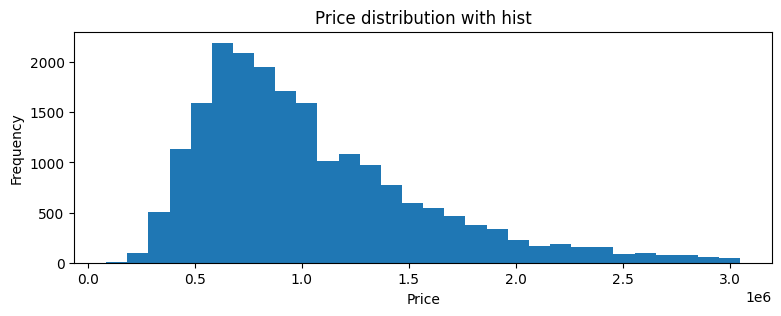

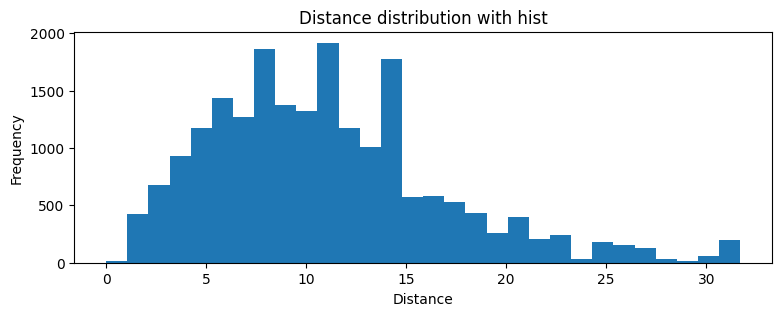

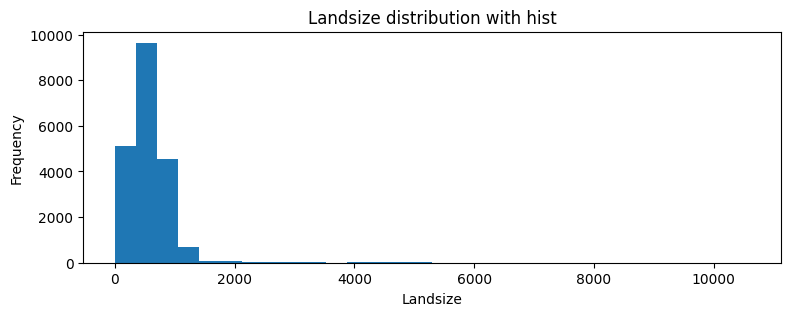

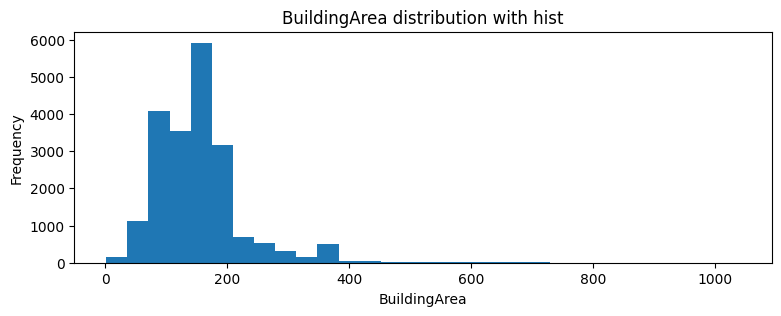

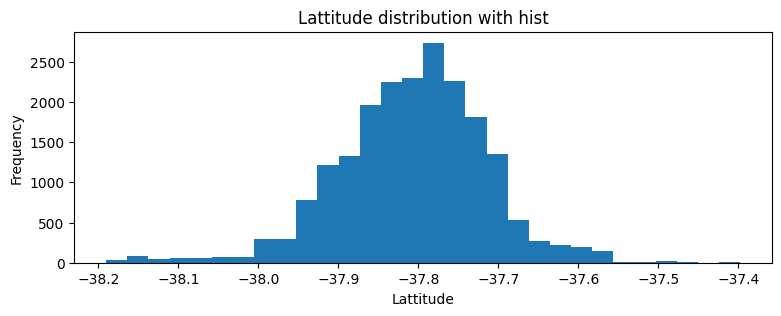

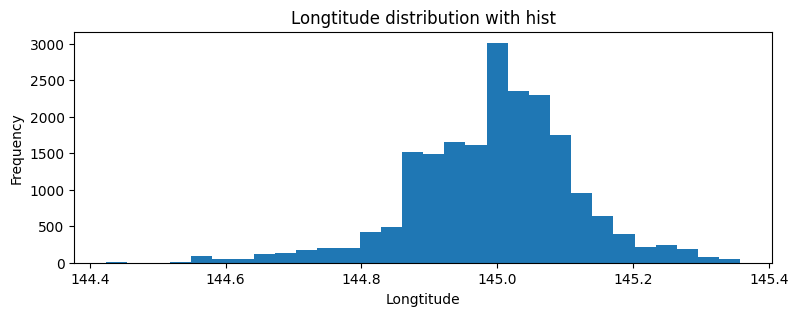

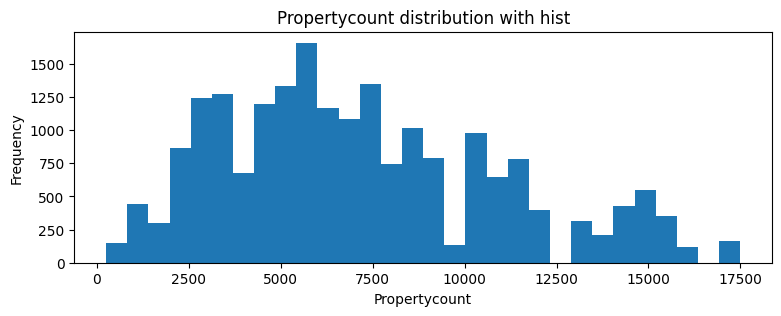

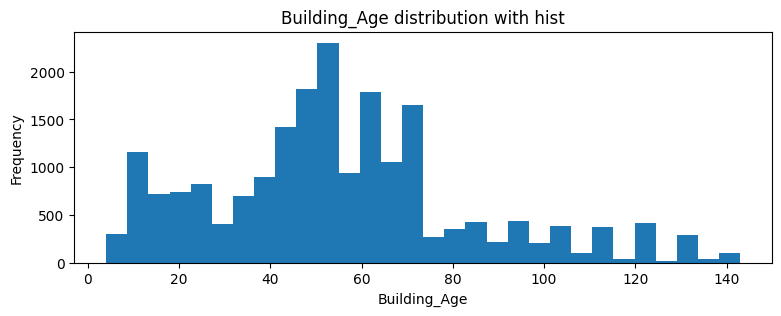

In [ ]:
for i in list(num_var.columns):
    plot_hist(data_copy,i)

<a id="9"></a><br>
## Univariate Variable Analysis

In this section we will examine univariate analysis of categorical. In outlier detection section was examine univariate analysis for numerical variable.

In [ ]:
object_columns=data_copy.select_dtypes(include="object").columns

In [ ]:
# Categorical variable
def bar_plot(data,variable):
    """
        input: variable exp: "Type"
        output: bar plot & value count
    """
    if len(data[variable].value_counts())>12:
        # get feature
        var=data[variable]
        # count number of categorical variable
        varValue=var.value_counts()[:12]
    else:
        var=data[variable]
        varValue=var.value_counts()

    # visualize
    plt.figure(figsize=(9,3))

    plt.bar(varValue.index,varValue,width=0.5)
    plt.xticks(varValue.index.to_list(),varValue.index.values,rotation = 90)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print(f"{variable}: \n {varValue}")

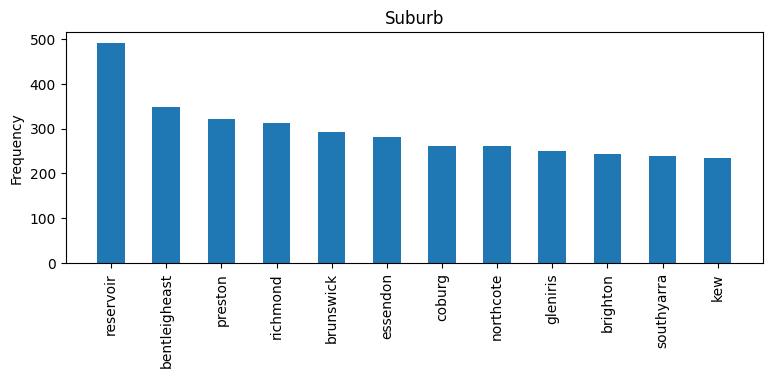

Suburb: 
 reservoir        491
bentleigheast    349
preston          321
richmond         312
brunswick        292
essendon         282
coburg           262
northcote        261
gleniris         250
brighton         243
southyarra       239
kew              234
Name: Suburb, dtype: int64


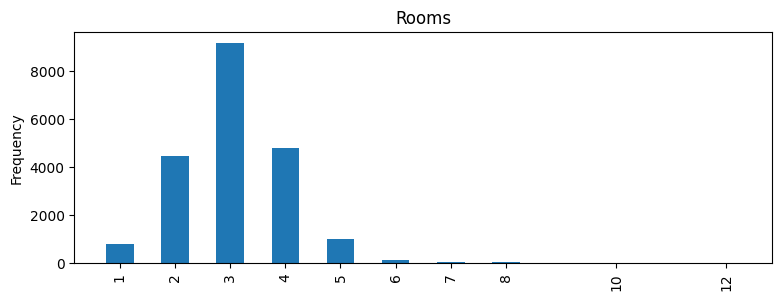

Rooms: 
 3     9191
4     4793
2     4476
5     1009
1      761
6      117
7       18
8       10
10       2
12       1
Name: Rooms, dtype: int64


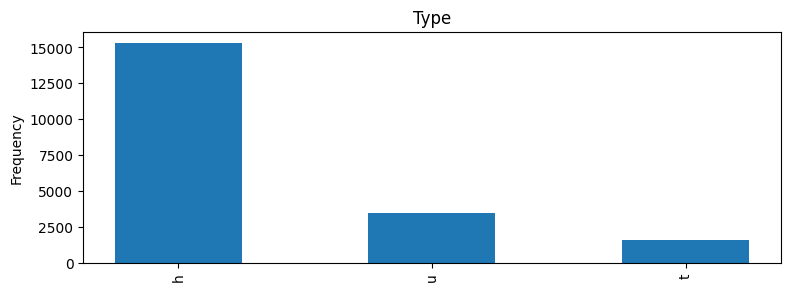

Type: 
 h    15334
u     3474
t     1570
Name: Type, dtype: int64


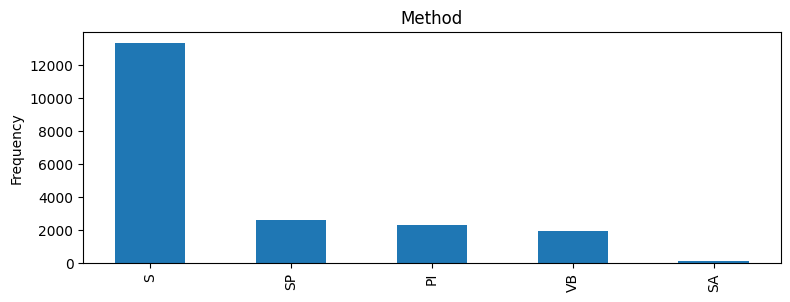

Method: 
 S     13330
SP     2600
PI     2340
VB     1963
SA      145
Name: Method, dtype: int64


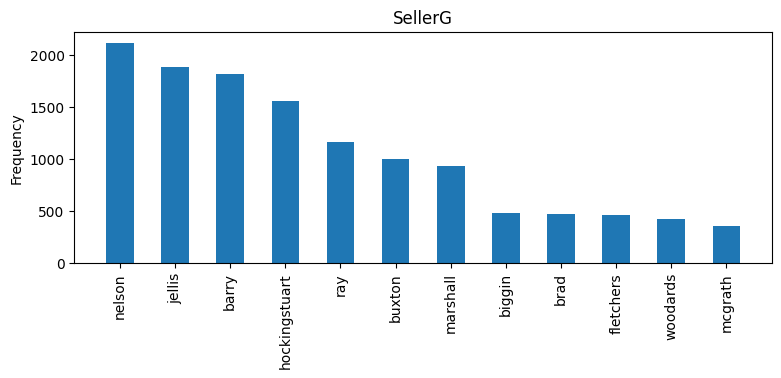

SellerG: 
 nelson           2119
jellis           1886
barry            1820
hockingstuart    1551
ray              1159
buxton            995
marshall          929
biggin            480
brad              471
fletchers         461
woodards          418
mcgrath           350
Name: SellerG, dtype: int64


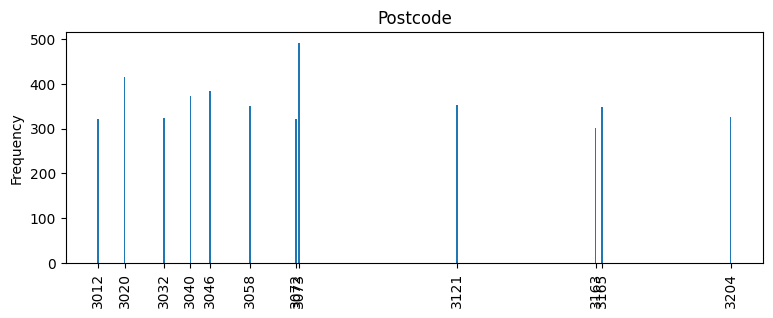

Postcode: 
 3073    491
3020    415
3046    384
3040    373
3121    352
3058    351
3165    349
3204    325
3032    323
3012    322
3072    321
3163    301
Name: Postcode, dtype: int64


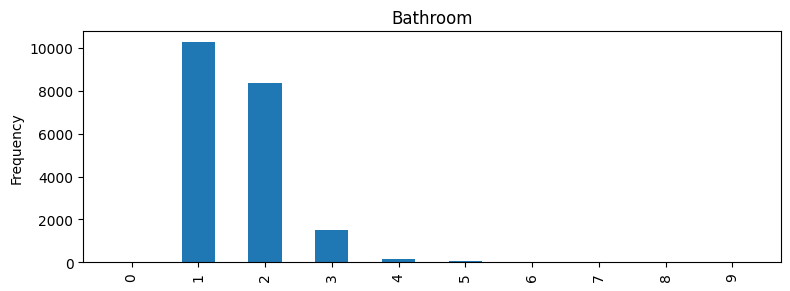

Bathroom: 
 1    10247
2     8336
3     1525
4      175
5       46
0       34
6       10
7        2
8        2
9        1
Name: Bathroom, dtype: int64


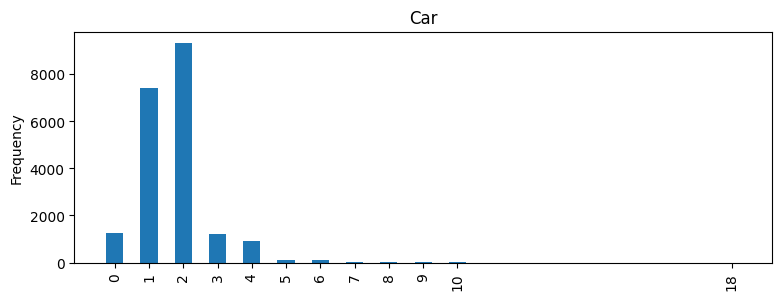

Car: 
 2     9340
1     7391
0     1250
3     1232
4      904
5      111
6      105
7       19
8       17
10       5
9        2
18       1
Name: Car, dtype: int64


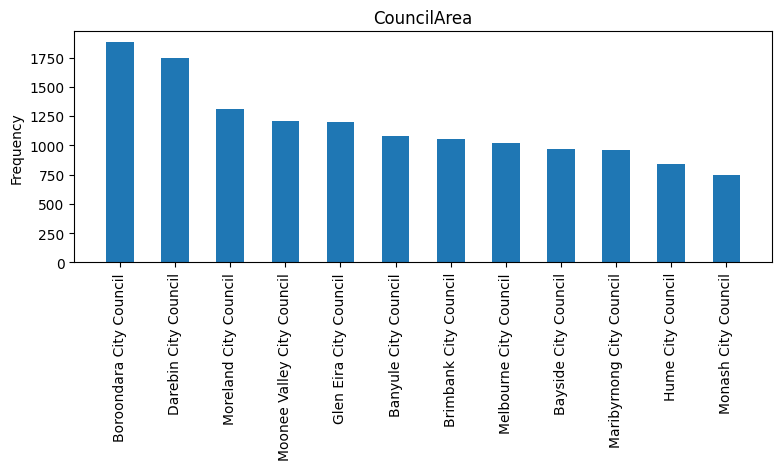

CouncilArea: 
 Boroondara City Council       1879
Darebin City Council          1742
Moreland City Council         1307
Moonee Valley City Council    1209
Glen Eira City Council        1195
Banyule City Council          1081
Brimbank City Council         1058
Melbourne City Council        1020
Bayside City Council           966
Maribyrnong City Council       960
Hume City Council              838
Monash City Council            745
Name: CouncilArea, dtype: int64


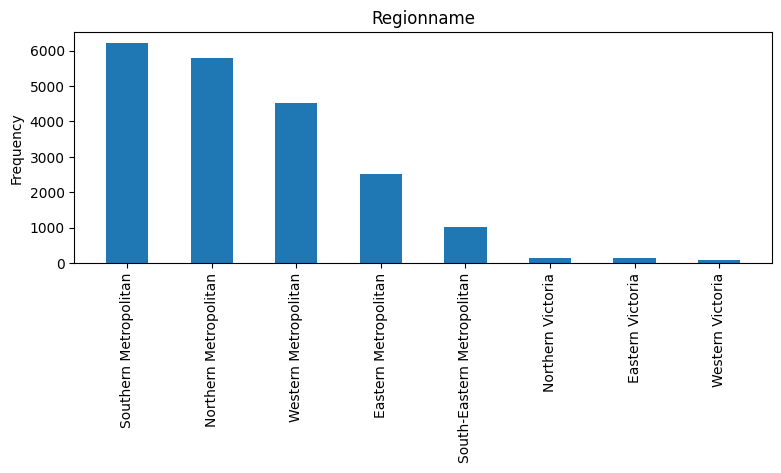

Regionname: 
 Southern Metropolitan         6213
Northern Metropolitan         5789
Western Metropolitan          4511
Eastern Metropolitan          2504
South-Eastern Metropolitan    1008
Northern Victoria              137
Eastern Victoria               133
Western Victoria                83
Name: Regionname, dtype: int64


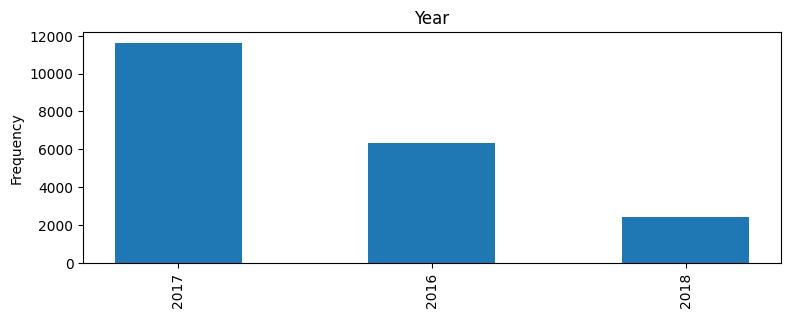

Year: 
 2017    11614
2016     6338
2018     2426
Name: Year, dtype: int64


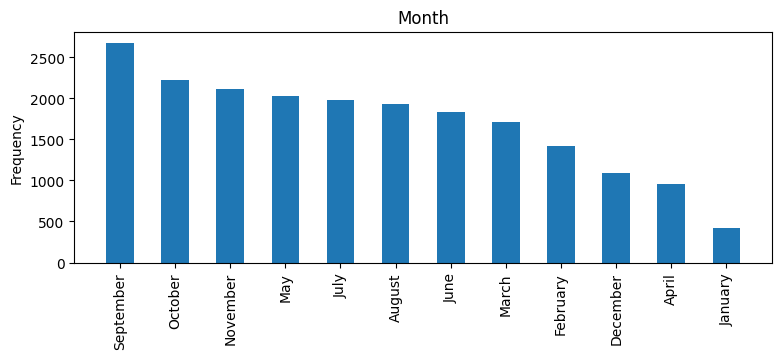

Month: 
 September    2679
October      2220
November     2114
May          2029
July         1984
August       1925
June         1832
March        1714
February     1414
December     1093
April         952
January       422
Name: Month, dtype: int64


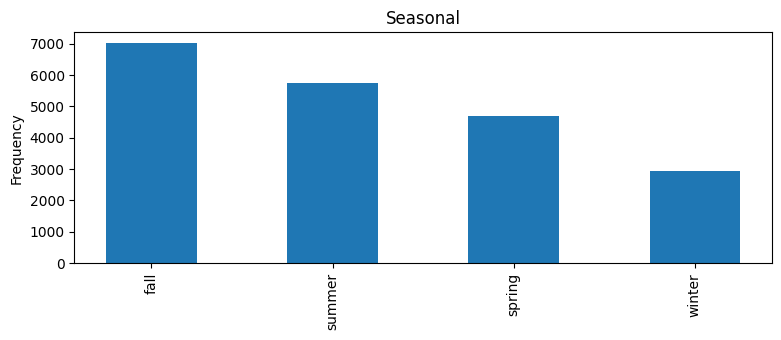

Seasonal: 
 fall      7013
summer    5741
spring    4695
winter    2929
Name: Seasonal, dtype: int64


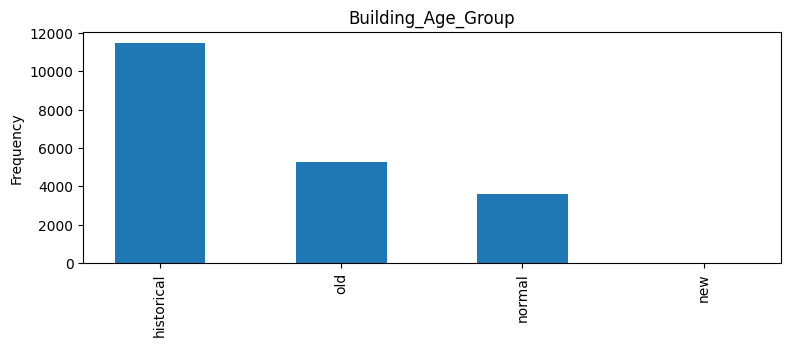

Building_Age_Group: 
 historical    11496
old            5273
normal         3604
new               5
Name: Building_Age_Group, dtype: int64


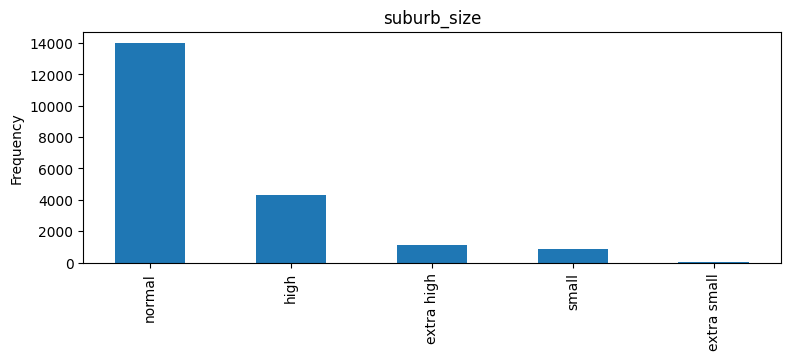

suburb_size: 
 normal         14031
high            4304
extra high      1129
small            887
extra small       27
Name: suburb_size, dtype: int64


In [ ]:
for i in object_columns:
    bar_plot(data_copy,i)

* Old and historical houses are more dominant in the data set
* Most of houses are in S. Met. , N. Met. and W. met regions.

<a id="10"></a><br>
## Exploratory Data Analysis

In this section, we will take a look at the relationships between variables.

Suburb vs price


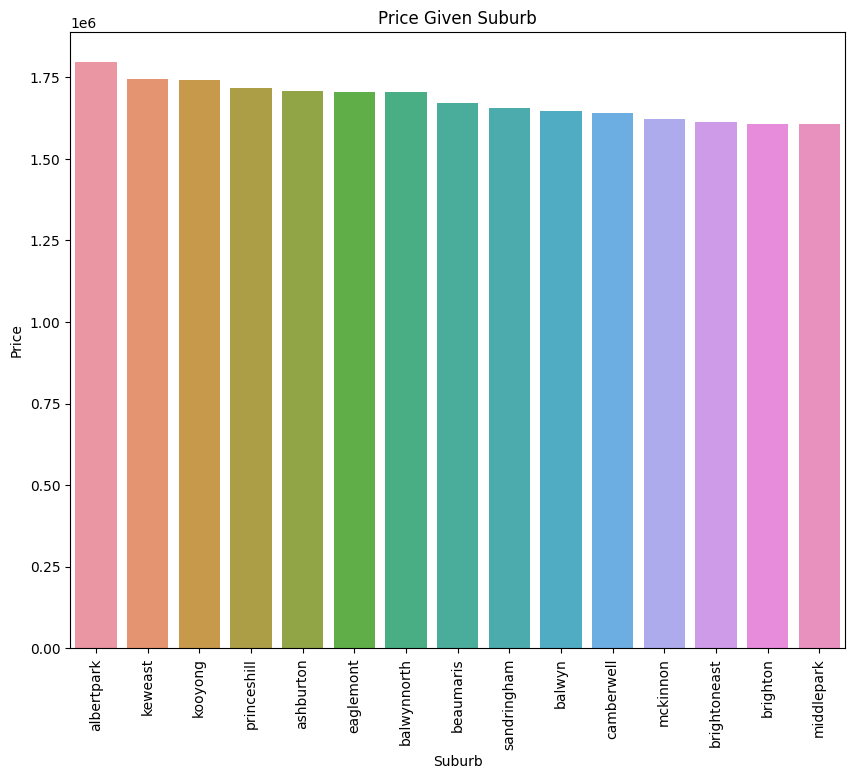

          Suburb        Price
0     albertpark 1,798,452.33
1        keweast 1,744,630.14
2        kooyong 1,743,125.16
3    princeshill 1,718,550.00
4      ashburton 1,707,687.51
5      eaglemont 1,705,556.83
6    balwynnorth 1,704,193.18
7      beaumaris 1,670,794.50
8    sandringham 1,656,570.77
9         balwyn 1,646,277.84
10    camberwell 1,642,092.59
11      mckinnon 1,622,136.36
12  brightoneast 1,614,658.26
13      brighton 1,606,763.45
14    middlepark 1,606,407.71
-------------
Rooms vs price


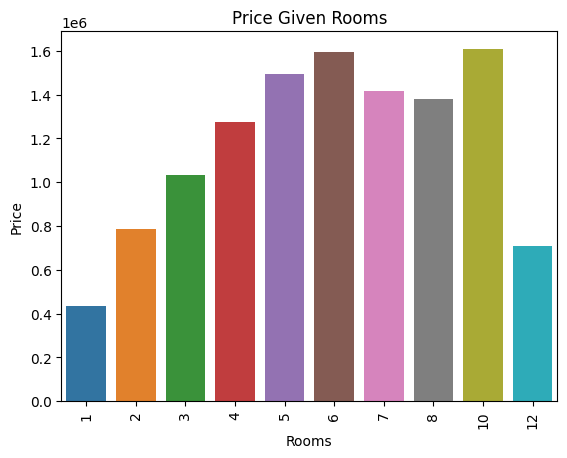

   Rooms        Price
0     10 1,607,500.00
1      6 1,594,690.21
2      5 1,494,287.78
3      7 1,418,180.61
4      8 1,377,925.00
5      4 1,276,731.46
6      3 1,031,426.57
7      2   784,879.53
8     12   710,000.00
9      1   434,310.71
-------------
Type vs price


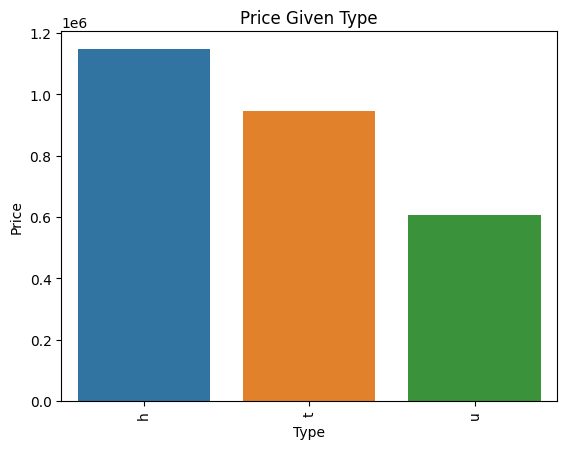

  Type        Price
0    h 1,147,241.56
1    t   944,839.59
2    u   605,985.34
-------------
Method vs price


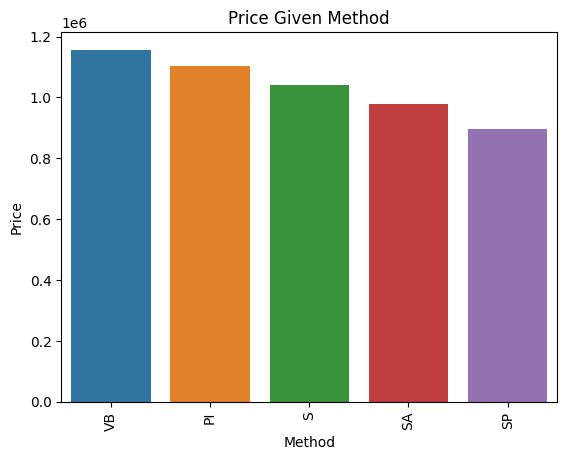

  Method        Price
0     VB 1,157,299.43
1     PI 1,103,480.78
2      S 1,039,521.94
3     SA   979,866.48
4     SP   895,215.94
-------------
SellerG vs price


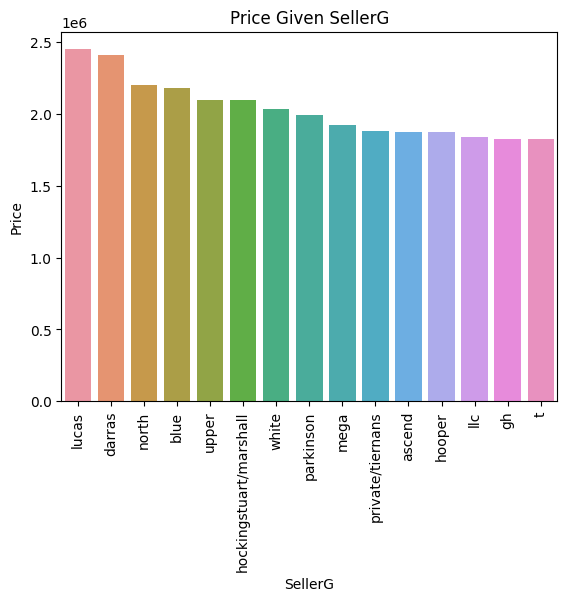

                   SellerG        Price
0                    lucas 2,450,000.00
1                   darras 2,410,000.00
2                    north 2,200,000.00
3                     blue 2,180,000.00
4                    upper 2,100,000.00
5   hockingstuart/marshall 2,100,000.00
6                    white 2,035,000.00
7                parkinson 1,992,500.00
8                     mega 1,925,000.00
9         private/tiernans 1,880,000.00
10                  ascend 1,876,700.00
11                  hooper 1,870,500.00
12                     llc 1,841,125.00
13                      gh 1,825,000.00
14                       t 1,825,000.00
-------------
Postcode vs price


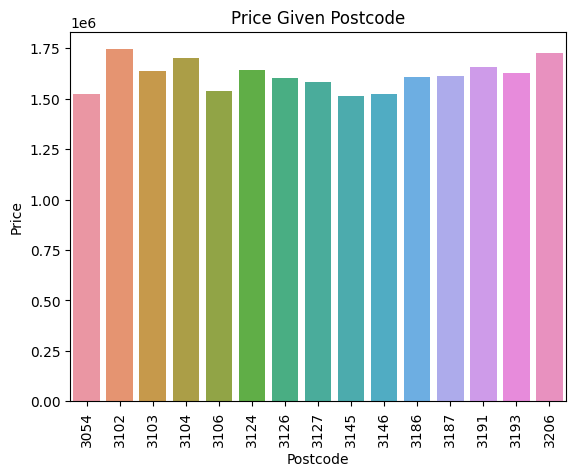

    Postcode        Price
0       3102 1,744,630.14
1       3206 1,726,042.07
2       3104 1,704,193.18
3       3191 1,656,570.77
4       3124 1,642,092.59
5       3103 1,636,704.18
6       3193 1,627,016.98
7       3187 1,614,658.26
8       3186 1,606,763.45
9       3126 1,600,852.22
10      3127 1,581,538.30
11      3106 1,537,782.80
12      3146 1,524,402.03
13      3054 1,522,331.36
14      3145 1,512,859.41
-------------
Bathroom vs price


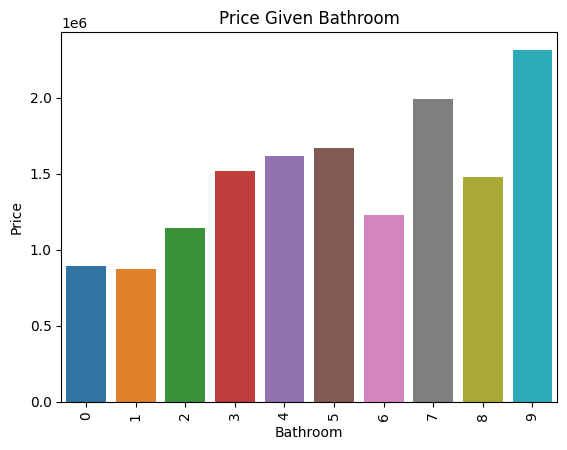

   Bathroom        Price
0         9 2,315,000.00
1         7 1,994,687.74
2         5 1,672,513.74
3         4 1,613,598.29
4         3 1,515,715.81
5         8 1,480,000.00
6         6 1,229,850.19
7         2 1,141,242.33
8         0   894,558.82
9         1   872,864.01
-------------
Car vs price


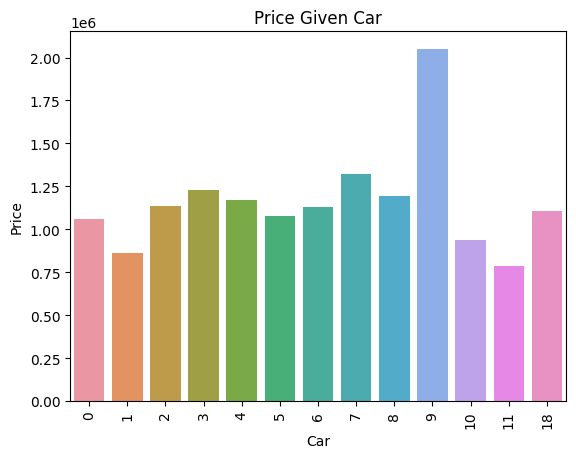

    Car        Price
0     9 2,050,000.00
1     7 1,322,355.31
2     3 1,228,245.28
3     8 1,195,198.56
4     4 1,167,937.24
5     2 1,138,017.97
6     6 1,127,416.69
7    18 1,105,000.00
8     5 1,075,908.82
9     0 1,061,680.04
10   10   937,400.00
11    1   860,677.08
12   11   788,000.00
-------------
CouncilArea vs price


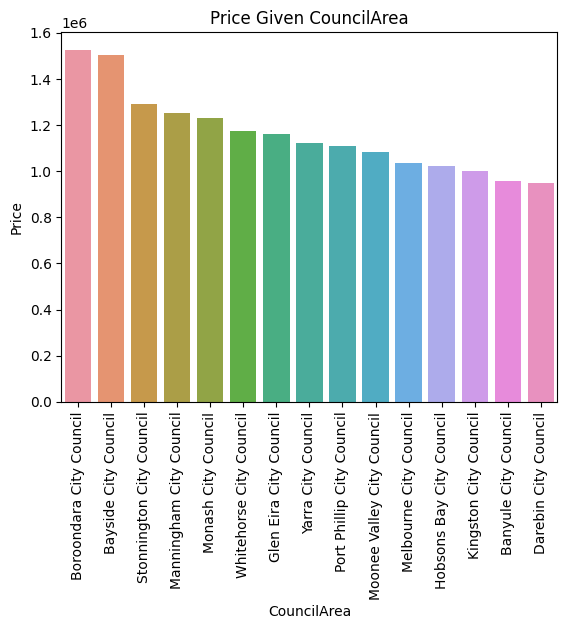

                   CouncilArea        Price
0      Boroondara City Council 1,526,457.14
1         Bayside City Council 1,504,710.74
2     Stonnington City Council 1,293,314.41
3      Manningham City Council 1,254,586.28
4          Monash City Council 1,230,703.83
5      Whitehorse City Council 1,175,807.90
6       Glen Eira City Council 1,161,901.86
7           Yarra City Council 1,121,231.75
8    Port Phillip City Council 1,111,240.74
9   Moonee Valley City Council 1,082,908.56
10      Melbourne City Council 1,035,970.55
11    Hobsons Bay City Council 1,021,302.62
12       Kingston City Council 1,003,149.99
13        Banyule City Council   957,821.13
14        Darebin City Council   949,237.21
-------------
Regionname vs price


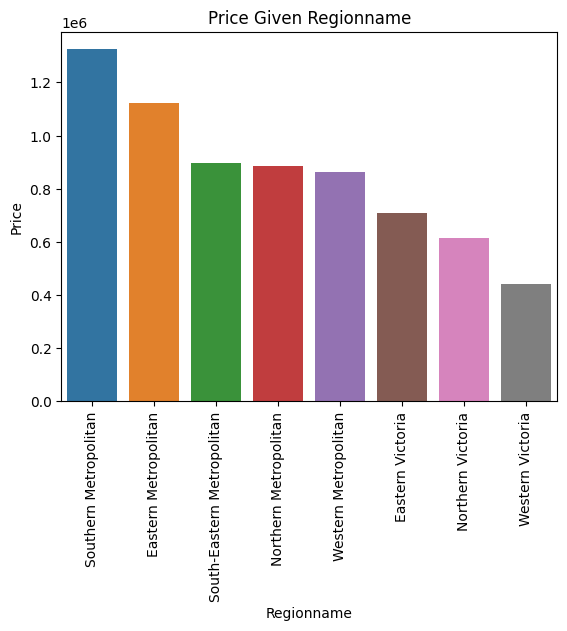

                   Regionname        Price
0       Southern Metropolitan 1,323,787.57
1        Eastern Metropolitan 1,124,302.66
2  South-Eastern Metropolitan   896,182.75
3       Northern Metropolitan   885,666.09
4        Western Metropolitan   863,441.44
5            Eastern Victoria   709,507.38
6           Northern Victoria   613,145.99
7            Western Victoria   441,256.02
-------------
Year vs price


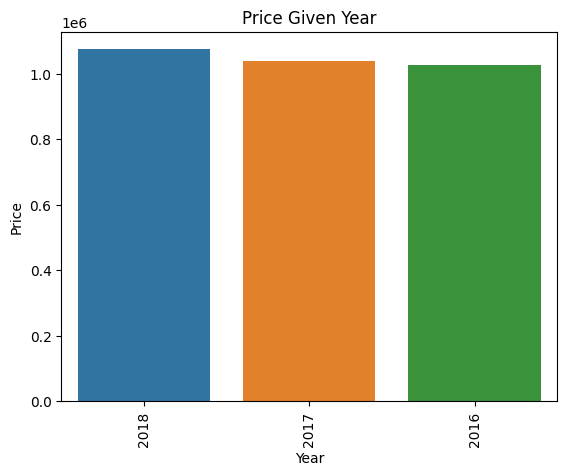

   Year        Price
0  2018 1,074,253.88
1  2017 1,039,124.81
2  2016 1,026,484.36
-------------
Month vs price


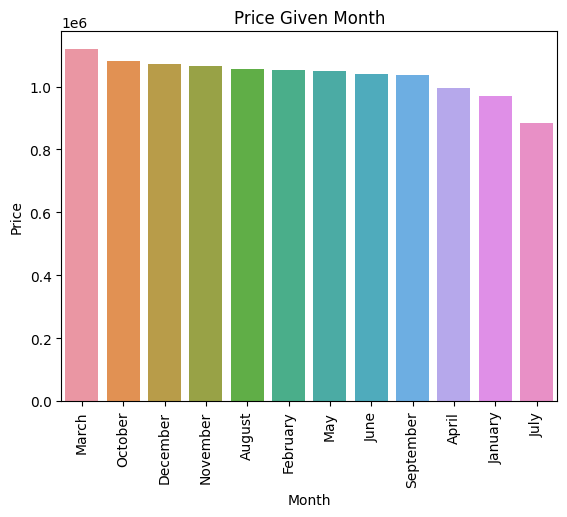

        Month        Price
0       March 1,119,421.54
1     October 1,081,204.16
2    December 1,072,138.08
3    November 1,064,735.91
4      August 1,055,428.25
5    February 1,052,118.43
6         May 1,048,726.75
7        June 1,038,711.12
8   September 1,035,789.10
9       April   995,802.74
10    January   971,355.57
11       July   884,958.42
-------------
Seasonal vs price


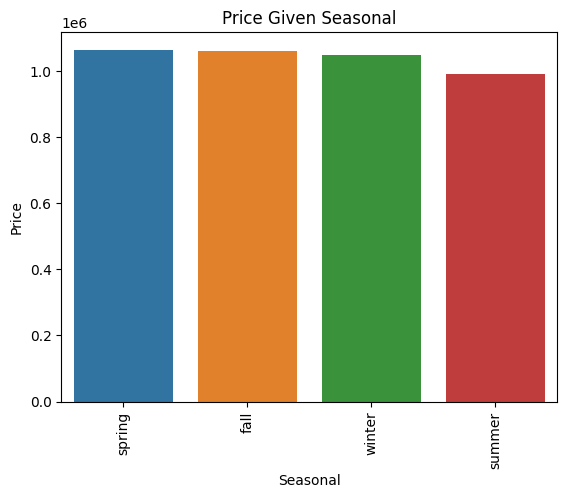

  Seasonal        Price
0   spring 1,063,803.90
1     fall 1,058,891.19
2   winter 1,047,953.03
3   summer   991,181.97
-------------
Building_Age_Group vs price


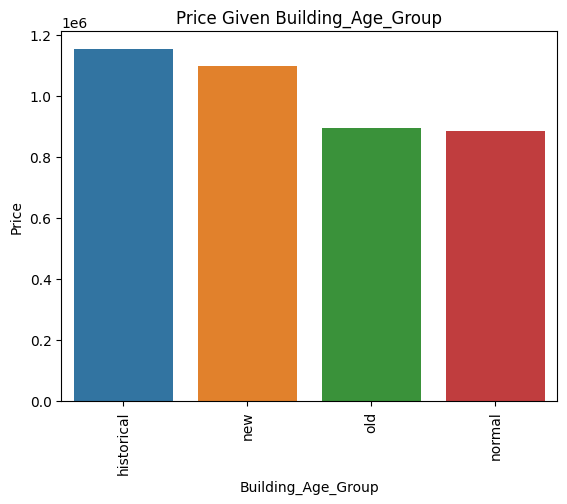

  Building_Age_Group        Price
0         historical 1,153,697.93
1                new 1,099,600.00
2                old   894,356.85
3             normal   886,803.63
-------------
suburb_size vs price


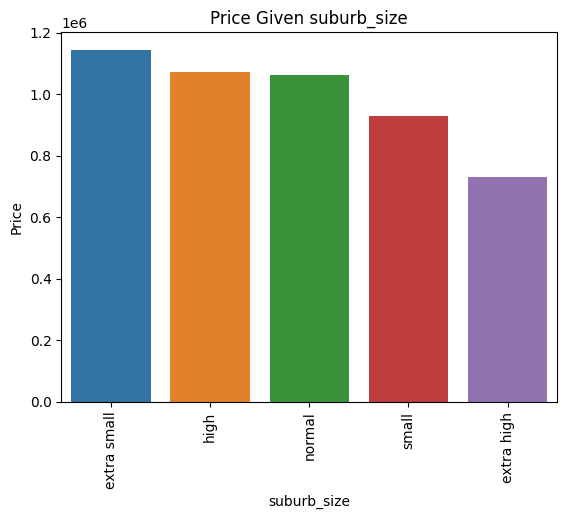

   suburb_size        Price
0  extra small 1,143,829.05
1         high 1,072,958.43
2       normal 1,060,496.80
3        small   930,365.45
4   extra high   732,003.69
-------------


In [ ]:
plt.figure(figsize=(10,8))
for i in data_copy.select_dtypes(include="object").columns:
    if len(data_copy[i].value_counts())>15:
        print(f"{i} vs price")
        df=data_copy[[i,"Price"]].groupby([i],as_index=False).mean().sort_values(by="Price",ascending=False)[:15].reset_index().drop("index",axis=1)
        sns.barplot(x=df[i],y=df["Price"])
        plt.xticks(rotation=90)
        plt.xlabel("{}".format(i))
        plt.ylabel("Price")
        plt.title("Price Given {}".format(i))
        plt.show()
        print(df)
        print("-------------")
    else:
        print(f"{i} vs price")
        df=data_copy[[i,"Price"]].groupby([i],as_index=False).mean().sort_values(by="Price",ascending=False).reset_index().drop("index",axis=1)
        sns.barplot(x=df[i],y=df["Price"])
        plt.xticks(rotation=90)
        plt.xlabel("{}".format(i))
        plt.ylabel("Price")
        plt.title("Price Given {}".format(i))
        plt.show()
        print(df)
        print("-------------")

We observed average prices across groups of categorical variables.

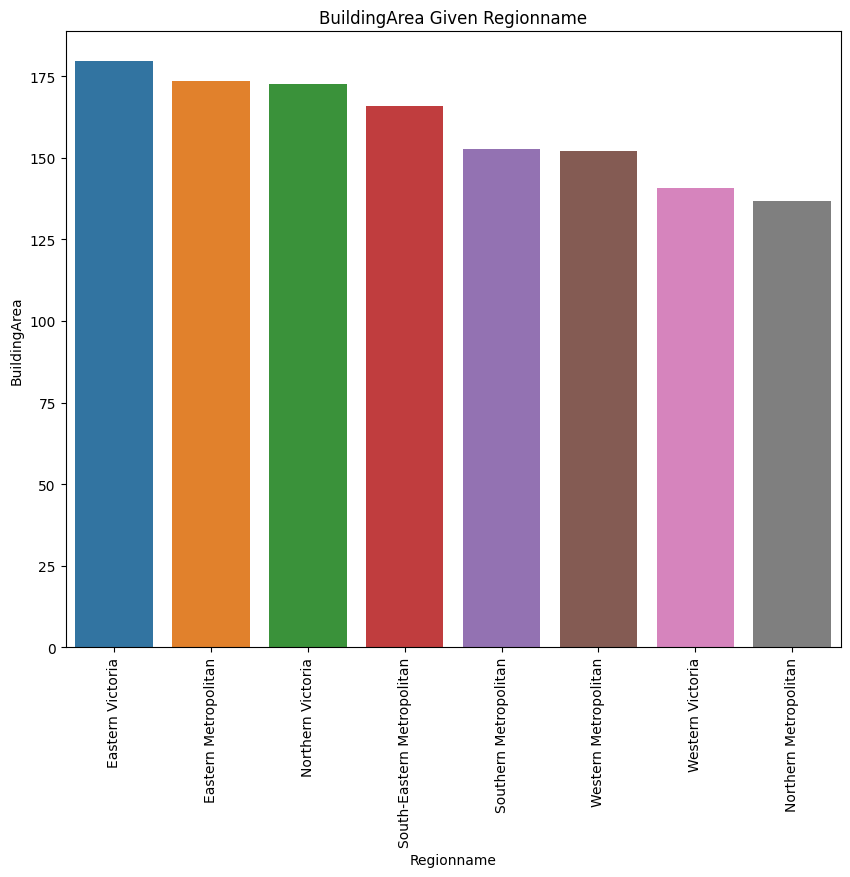

In [ ]:
avbar=data_copy[["Regionname","BuildingArea"]].groupby(["Regionname"],as_index=False).mean().sort_values(by="BuildingArea",ascending=False).reset_index().drop("index",axis=1)

plt.figure(figsize=(10,8))
sns.barplot(x=avbar["Regionname"],y=avbar["BuildingArea"])
plt.xticks(rotation=90)
plt.xlabel("Regionname")
plt.ylabel("BuildingArea")
plt.title("BuildingArea Given Regionname")
plt.show()

The largest houses are in Eastern Victoria.

Building Age and Building Area vs Price of each region:

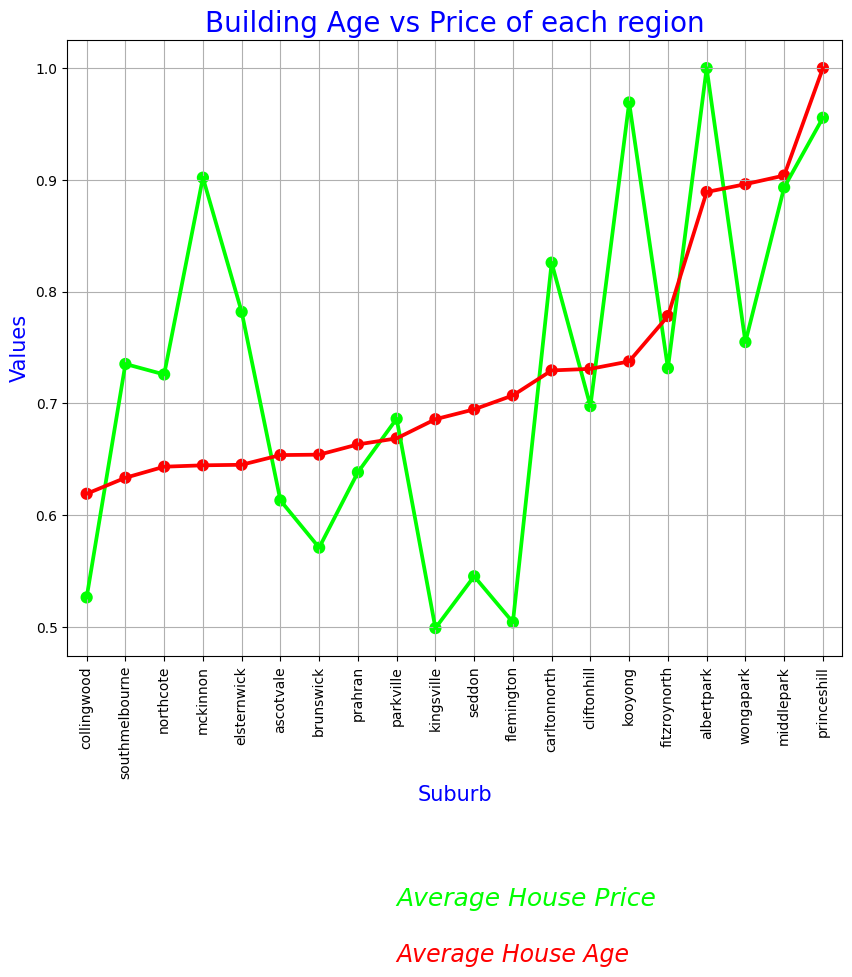

In [ ]:
area_list=list(data_copy["Suburb"].unique())
avg_build_age=[]
avg_price=[]

for i in area_list:
    x=data_copy[data_copy["Suburb"]==i]
    avg_build_age.append(sum(x["Building_Age"])/len(x))
    avg_price.append(sum(x["Price"])/len(x))

df=pd.DataFrame({"Suburb":area_list,"AvgAge":avg_build_age,"AvgPrice":avg_price,})
new_index=(df["AvgAge"].sort_values(ascending=False)).index.values
sorted_data=df.reindex(new_index)
# we will use normalization for our data because of have to plot meaningful.
sorted_data["AvgAge"]=sorted_data["AvgAge"]/max(sorted_data["AvgAge"])
sorted_data["AvgPrice"]=sorted_data["AvgPrice"]/max(sorted_data["AvgPrice"])
sorted_data.sort_values(by="AvgAge",inplace=True)
sorted_data=sorted_data[-20:]

# visualize: Pointplot
f,ax1=plt.subplots(figsize=(10,8))
sns.pointplot(x="Suburb",y="AvgPrice",data=sorted_data,color="lime")
sns.pointplot(x="Suburb",y="AvgAge",data=sorted_data,color="red")
plt.text(8,0.2,"Average House Age",color="red",fontsize=17,style="italic")
plt.text(8,0.25,"Average House Price",color="lime",fontsize=18,style="italic")
plt.xlabel("Suburb",fontsize=15,color="blue")
plt.ylabel("Values",fontsize=15,color="blue")
plt.title("Building Age vs Price of each region",fontsize=20,color="blue")
plt.xticks(rotation=90)
plt.grid()
plt.show()

There are expensive historical houses in Albertpark, Middlepark and Princeshill Suburb.

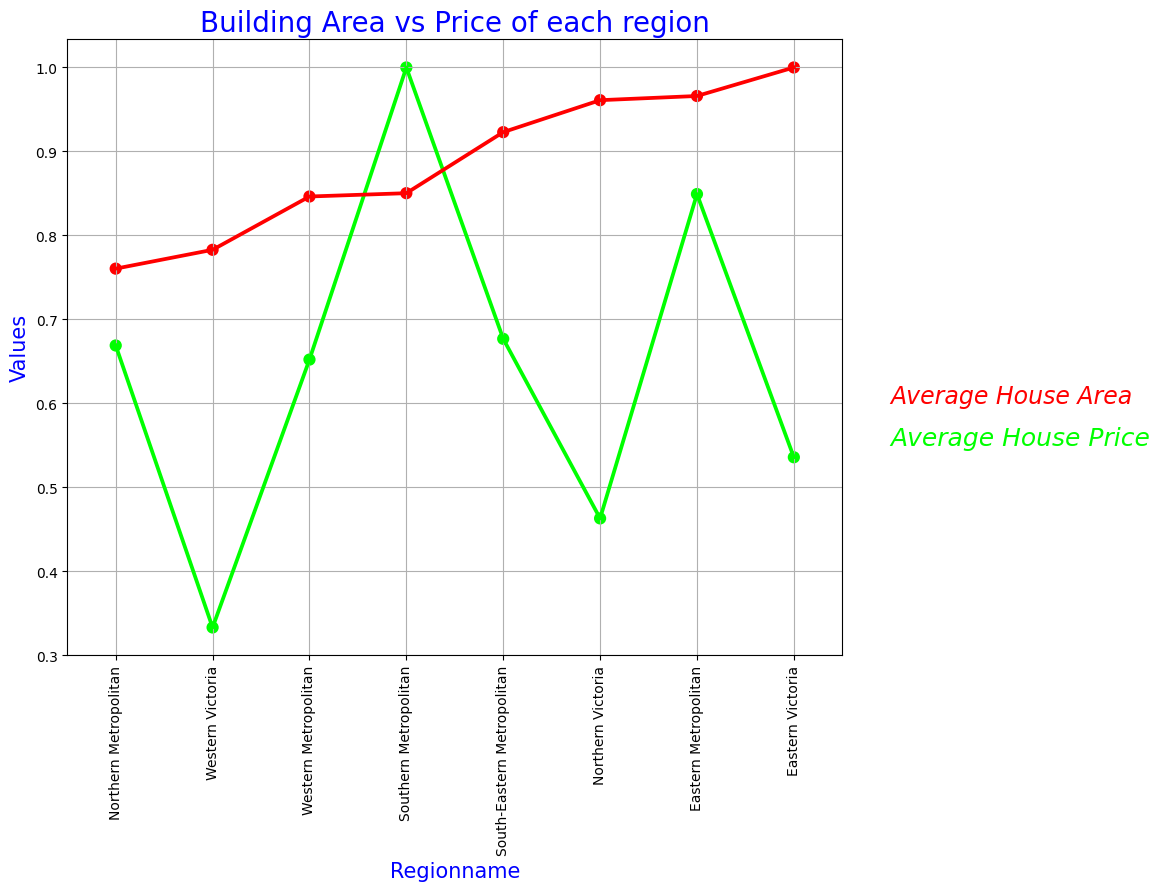

In [ ]:
area_list=list(data_copy["Regionname"].unique())
avg_build_area=[]
avg_price=[]

for i in area_list:
    x=data_copy[data_copy["Regionname"]==i]
    avg_build_area.append(sum(x["BuildingArea"])/len(x))
    avg_price.append(sum(x["Price"])/len(x))

df=pd.DataFrame({"Regionname":area_list,"AvgArea":avg_build_area,"AvgPrice":avg_price,})
new_index=(df["AvgArea"].sort_values(ascending=False)).index.values
sorted_data=df.reindex(new_index)

# we will use normalization for our data because of have to plot meaningful.
sorted_data["AvgArea"]=sorted_data["AvgArea"]/max(sorted_data["AvgArea"])
sorted_data["AvgPrice"]=sorted_data["AvgPrice"]/max(sorted_data["AvgPrice"])
sorted_data.sort_values(by="AvgArea",inplace=True)

# visualize: Pointplot
f,ax1=plt.subplots(figsize=(10,8))
sns.pointplot(x="Regionname",y="AvgPrice",data=sorted_data,color="lime")
sns.pointplot(x="Regionname",y="AvgArea",data=sorted_data,color="red")
plt.text(8,0.6,"Average House Area",color="red",fontsize=17,style="italic")
plt.text(8,0.55,"Average House Price",color="lime",fontsize=18,style="italic")
plt.xlabel("Regionname",fontsize=15,color="blue")
plt.ylabel("Values",fontsize=15,color="blue")
plt.title("Building Area vs Price of each region",fontsize=20,color="blue")
plt.xticks(rotation=90)
plt.grid()
plt.show()

There are large and affordable houses in the Northern Victoria and Eastern Victoria regions.

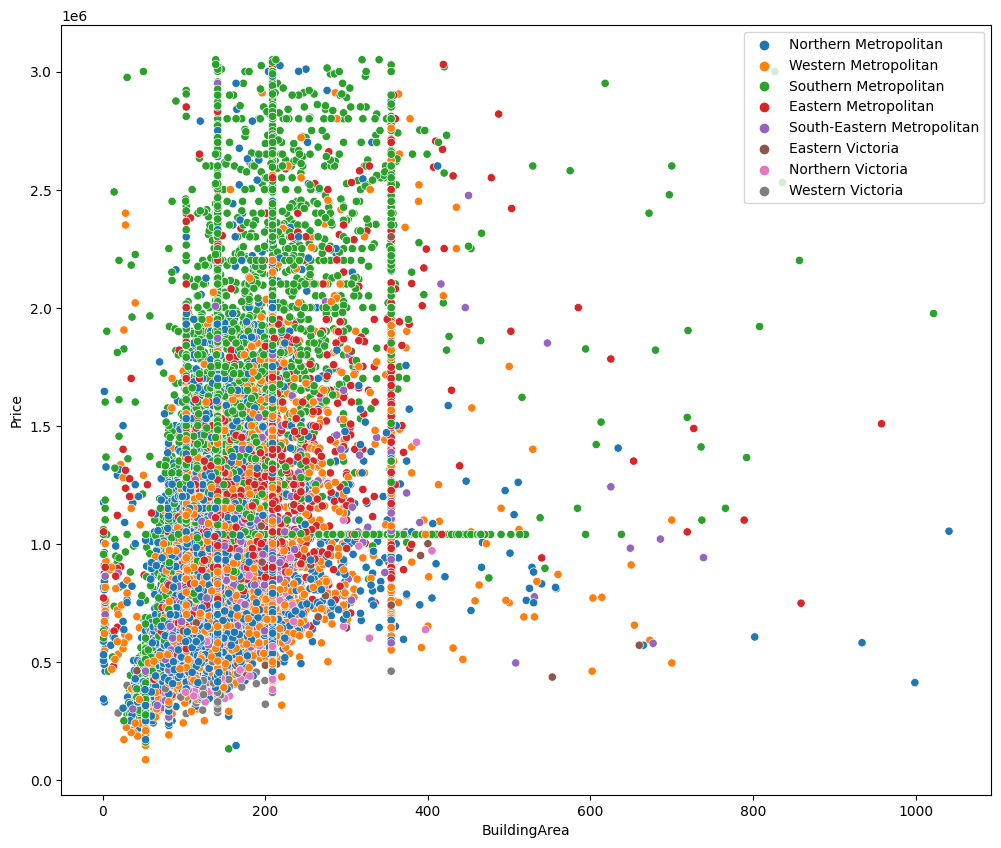

In [ ]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=data_copy,x="BuildingArea",y="Price",hue="Regionname")
plt.xlabel("BuildingArea")
plt.ylabel("Price")
plt.legend()
plt.show()

* Houses with large areas and the highest prices are in Southern Metropolitan.
* Houses with small areas and the highest prices are in Southern Metropolitan.

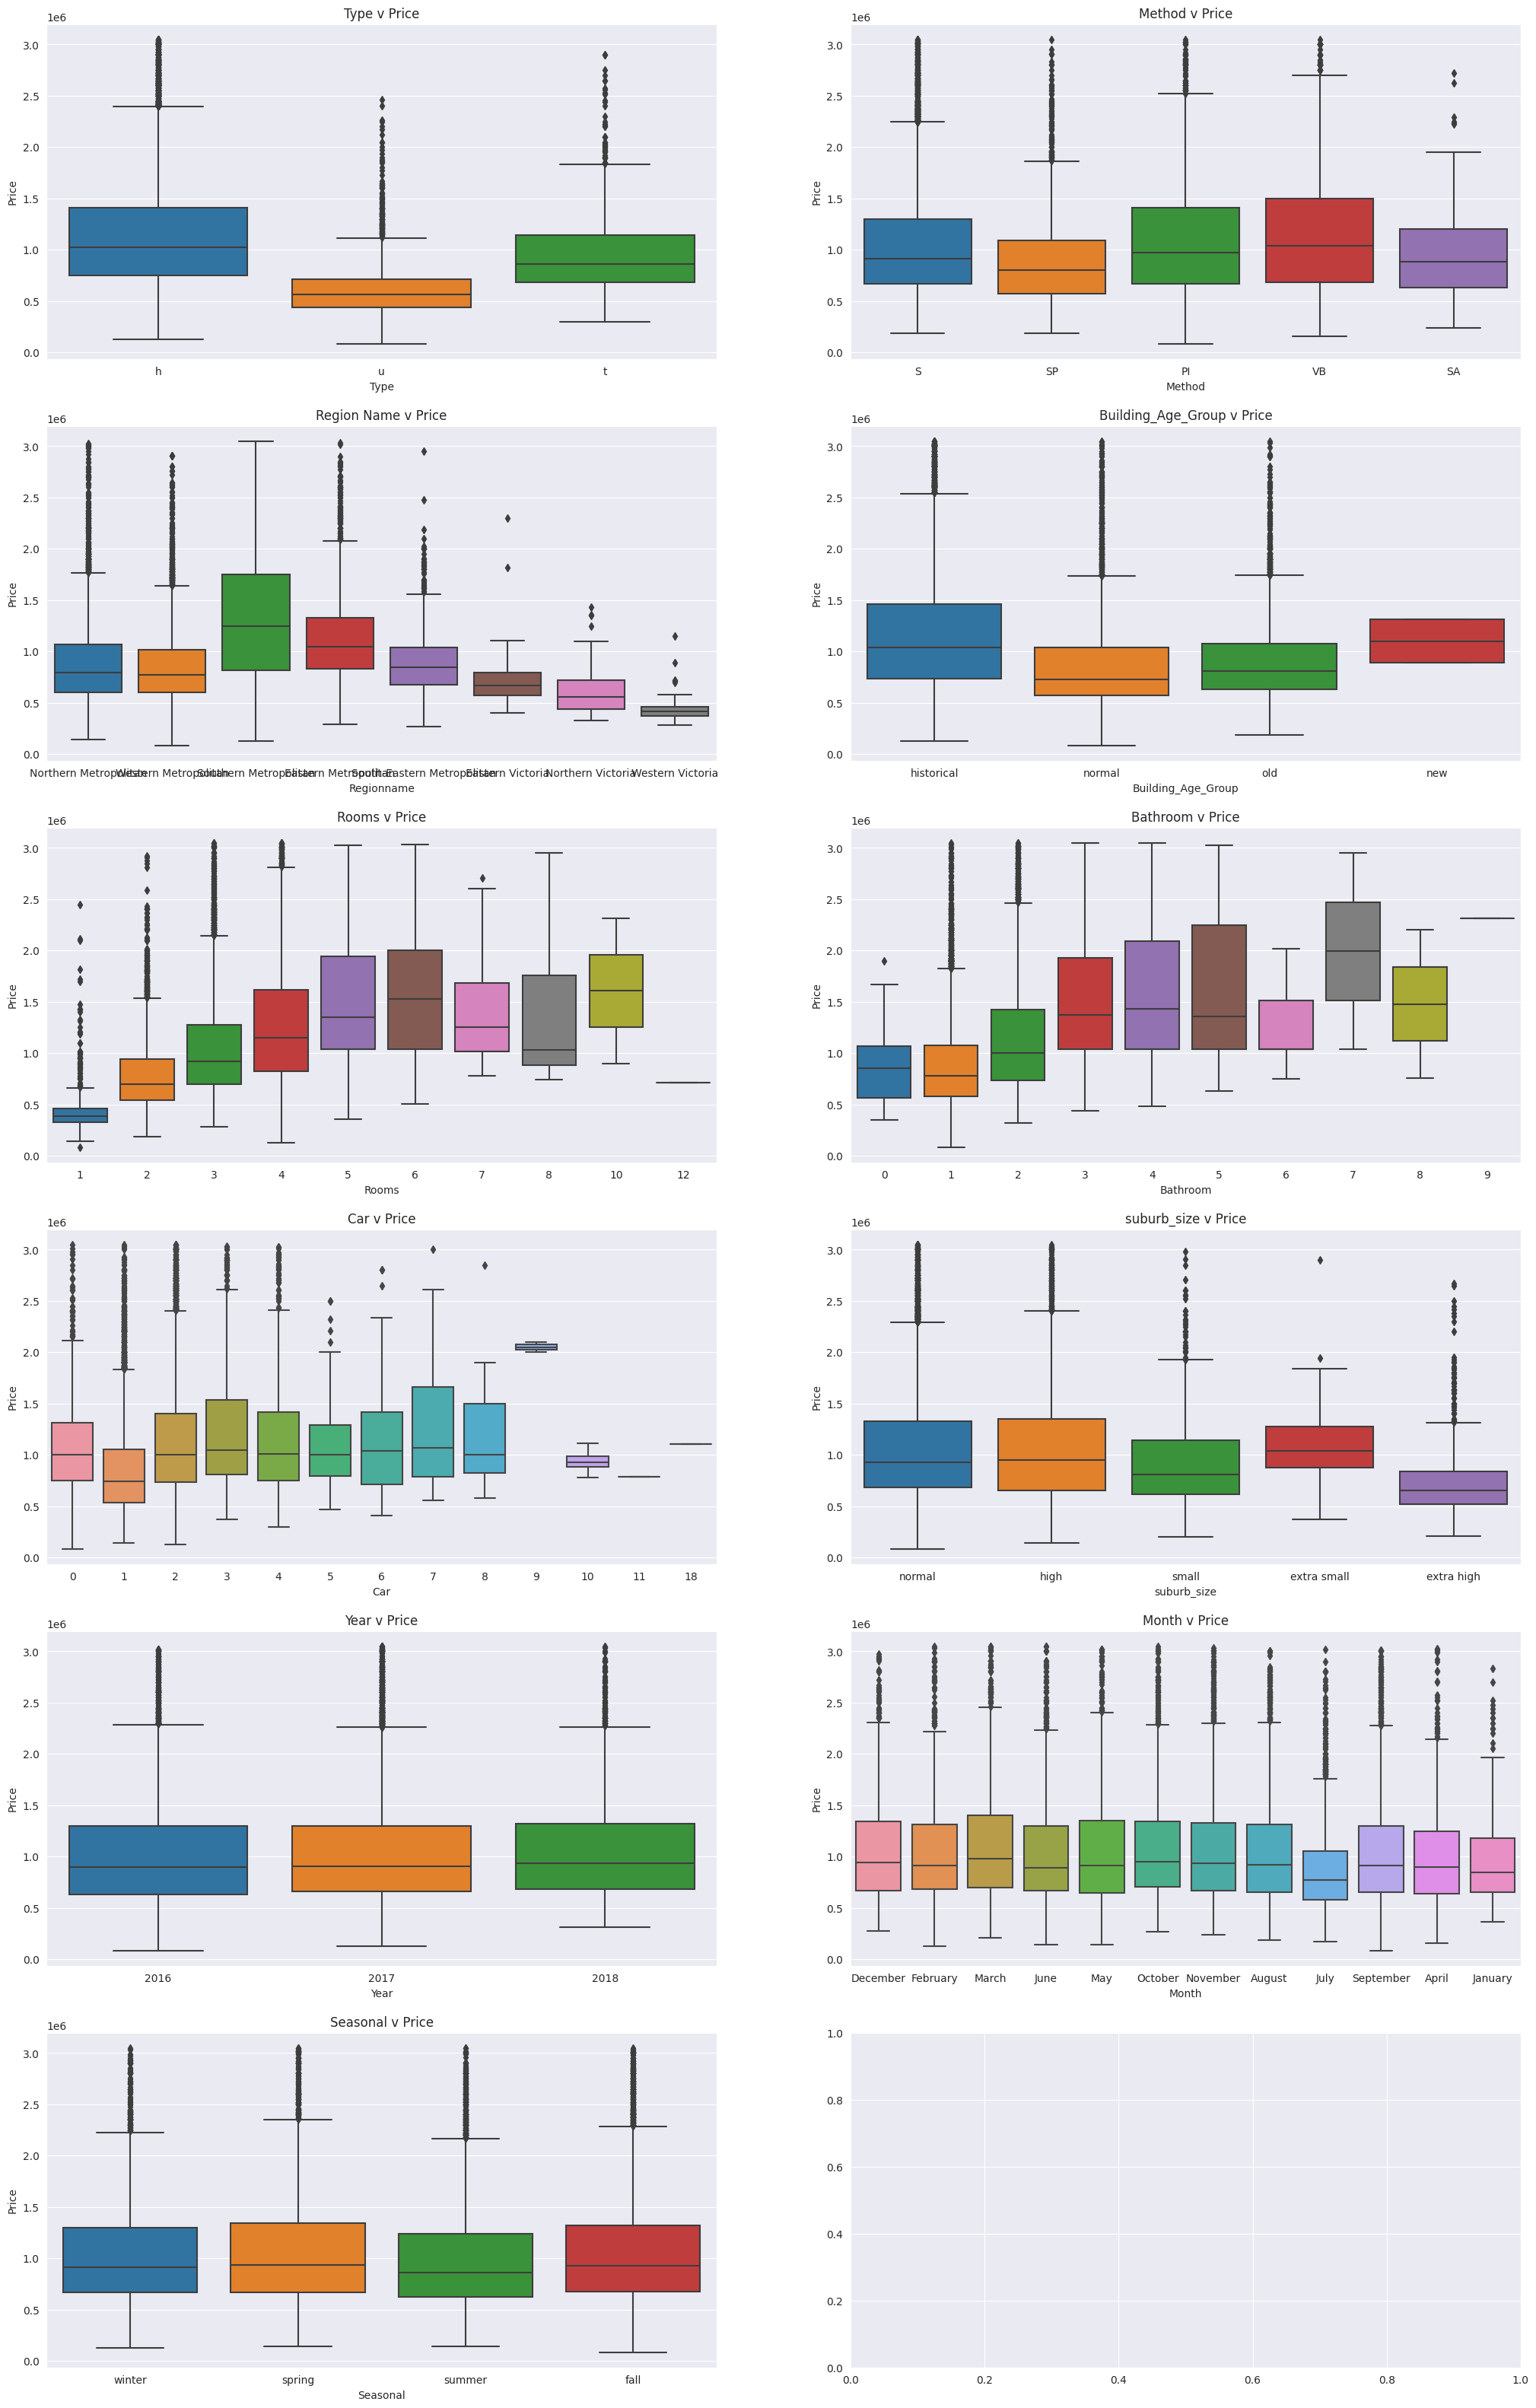

In [ ]:
# Suplots of categorical features v price
sns.set_style('darkgrid')
f, axes = plt.subplots(6,2, figsize = (25,40))

# Plot [0,0]
sns.boxplot(data = data_copy, x = 'Type', y = 'Price', ax = axes[0,0])
axes[0,0].set_xlabel('Type')
axes[0,0].set_ylabel('Price')
axes[0,0].set_title('Type v Price')

# Plot [0,1]
sns.boxplot(x = 'Method', y = 'Price', data = data_copy, ax = axes[0,1])
axes[0,1].set_xlabel('Method')
#axes[0,1].set_ylabel('Price')
axes[0,1].set_title('Method v Price')

# Plot [1,0]
sns.boxplot(x = 'Regionname', y = 'Price', data = data_copy, ax = axes[1,0])
axes[1,0].set_xlabel('Regionname')
#axes[1,0].set_ylabel('Price')
axes[1,0].set_title('Region Name v Price')

# Plot [1,1]
sns.boxplot(x = 'Building_Age_Group', y = 'Price', data = data_copy, ax = axes[1,1])
axes[1,1].set_xlabel('Building_Age_Group')
axes[1,1].set_ylabel('Price')
axes[1,1].set_title('Building_Age_Group v Price')

# Plot [2,0]
sns.boxplot(data = data_copy, x = 'Rooms', y = 'Price', ax = axes[2,0])
axes[2,0].set_xlabel('Rooms')
axes[2,0].set_ylabel('Price')
axes[2,0].set_title('Rooms v Price')

# Plot [2,1]
sns.boxplot(x = 'Bathroom', y = 'Price', data = data_copy, ax = axes[2,1])
axes[2,1].set_xlabel('Bathroom')
axes[2,1].set_ylabel('Price')
axes[2,1].set_title('Bathroom v Price')

# Plot [3,0]
sns.boxplot(x = 'Car', y = 'Price', data = data_copy, ax = axes[3,0])
axes[3,0].set_xlabel('Car')
axes[3,0].set_ylabel('Price')
axes[3,0].set_title('Car v Price')

# Plot [3,1]
sns.boxplot(x = 'suburb_size', y = 'Price', data = data_copy, ax = axes[3,1])
axes[3,1].set_xlabel('suburb_size')
axes[3,1].set_ylabel('Price')
axes[3,1].set_title('suburb_size v Price')

# Plot [4,0]
sns.boxplot(data = data_copy, x = 'Year', y = 'Price', ax = axes[4,0])
axes[4,0].set_xlabel('Year')
axes[4,0].set_ylabel('Price')
axes[4,0].set_title('Year v Price')

# Plot [4,1]
sns.boxplot(x = 'Month', y = 'Price', data = data_copy, ax = axes[4,1])
axes[4,1].set_xlabel('Month')
axes[4,1].set_ylabel('Price')
axes[4,1].set_title('Month v Price')

# Plot [5,0]
sns.boxplot(x = 'Seasonal', y = 'Price', data = data_copy, ax = axes[5,0])
axes[5,0].set_xlabel('Seasonal')
axes[5,0].set_ylabel('Price')
axes[5,0].set_title('Seasonal v Price')

plt.show()

The effect of categorical variables on the dependent variable is observed.

In [ ]:
# correlation analysis
df_corr=data_copy.select_dtypes(include=["float64","int64"]).corr()

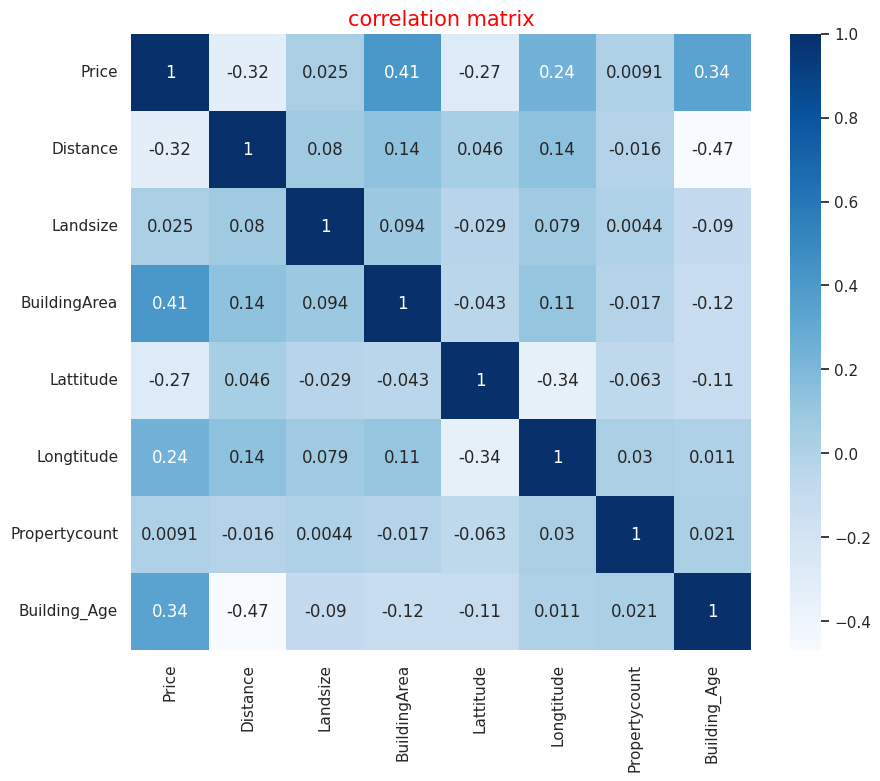

In [ ]:
plt.figure(figsize=(10,8))
plt.title("correlation matrix", color="red", fontsize=15)
sns.heatmap(df_corr,annot=True,cmap="Blues")
sns.set(font_scale=1,style='white')
plt.show()

* Building area and building age variables have a high correlation with the dependent variable.
* There does not seem to be a high correlation between the independent variables.

In [ ]:
cat_vars=data_copy.select_dtypes(include="object")
cat_vars=cat_vars.join(data_copy["Price"])

for i in cat_vars.columns[:-1]:
    print("Categorical variable: {} - Unique values: {}".format(i,len(cat_vars[i].unique())))

Categorical variable: Suburb - Unique values: 316
Categorical variable: Rooms - Unique values: 10
Categorical variable: Type - Unique values: 3
Categorical variable: Method - Unique values: 5
Categorical variable: SellerG - Unique values: 288
Categorical variable: Postcode - Unique values: 195
Categorical variable: Bathroom - Unique values: 10
Categorical variable: Car - Unique values: 13
Categorical variable: CouncilArea - Unique values: 33
Categorical variable: Regionname - Unique values: 8
Categorical variable: Year - Unique values: 3
Categorical variable: Month - Unique values: 12
Categorical variable: Seasonal - Unique values: 4
Categorical variable: Building_Age_Group - Unique values: 4
Categorical variable: suburb_size - Unique values: 5


The number of groups of categorical variables are grather than 2. So we will use the anova test to measure the relationships of these variables with the independent variable.

Let's examine the relationships between independent categorical variables with the chi-square test:

In [ ]:
le=LabelEncoder()

for i in cat_vars.columns:
    cat_vars[i]=le.fit_transform(cat_vars[i])

cat_vars.head()

,Suburb,Rooms,Type,Method,SellerG,Postcode,Bathroom,Car,CouncilArea,Regionname,Year,Month,Seasonal,Building_Age_Group,suburb_size,Price
0,0,1,0,1,24,52,1,1,31,2,0,2,3,0,3,1585
1,0,1,0,1,24,52,1,0,31,2,0,3,3,0,3,1123
2,0,2,0,3,24,52,2,0,31,2,1,7,1,0,3,1572
3,0,2,0,0,24,52,2,1,31,2,1,7,1,0,3,845
4,0,3,0,4,183,52,1,2,31,2,0,6,2,2,3,1669


In [ ]:
# Suburb and Postcode have a high relationship.
data_copy.drop("Postcode",axis=1,inplace=True)

In [ ]:
# Type, Suburb and Rooms have a high relationship.
data_copy.drop(["Suburb","Rooms"],axis=1,inplace=True)

In [ ]:
# Type and Car have a high relationship.
data_copy.drop("Car",axis=1,inplace=True)

In [ ]:
# Building_Age_Group and SellerG have a high relationship.
data_copy.drop("SellerG",axis=1,inplace=True)

In [ ]:
data_copy.head()

,Type,Price,Method,Distance,Bathroom,Landsize,BuildingArea,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Building_Age,Year,Month,Seasonal,Building_Age_Group,suburb_size
0,h,"1,480,000.00",S,2.50,1,202.00,103.45,Yarra City Council,-37.80,145.00,Northern Metropolitan,"4,019.00",89.00,2016,December,winter,historical,normal
1,h,"1,035,000.00",S,2.50,1,156.00,79.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,"4,019.00",123.00,2016,February,winter,historical,normal
2,h,"1,465,000.00",SP,2.50,2,134.00,150.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,"4,019.00",123.00,2017,March,spring,historical,normal
3,h,"850,000.00",PI,2.50,2,94.00,141.05,Yarra City Council,-37.80,145.00,Northern Metropolitan,"4,019.00",89.00,2017,March,spring,historical,normal
4,h,"1,600,000.00",VB,2.50,1,120.00,142.00,Yarra City Council,-37.81,144.99,Northern Metropolitan,"4,019.00",9.00,2016,June,summer,normal,normal


<a id="12"></a><br>
# Model Building

After encoding and scaling we will training the linear model.

In [ ]:
cat_columns=data_copy.select_dtypes(include="object").columns.tolist()
cat_columns

['Type',
 'Method',
 'Bathroom',
 'CouncilArea',
 'Regionname',
 'Year',
 'Month',
 'Seasonal',
 'Building_Age_Group',
 'suburb_size']

In [ ]:
le=LabelEncoder()

for i in cat_columns:
    data_copy[i]=le.fit_transform(data_copy[i])

data_copy.head()

,Type,Price,Method,Distance,Bathroom,Landsize,BuildingArea,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Building_Age,Year,Month,Seasonal,Building_Age_Group,suburb_size
0,0,"1,480,000.00",1,2.50,1,202.00,103.45,31,-37.80,145.00,2,"4,019.00",89.00,0,2,3,0,3
1,0,"1,035,000.00",1,2.50,1,156.00,79.00,31,-37.81,144.99,2,"4,019.00",123.00,0,3,3,0,3
2,0,"1,465,000.00",3,2.50,2,134.00,150.00,31,-37.81,144.99,2,"4,019.00",123.00,1,7,1,0,3
3,0,"850,000.00",0,2.50,2,94.00,141.05,31,-37.80,145.00,2,"4,019.00",89.00,1,7,1,0,3
4,0,"1,600,000.00",4,2.50,1,120.00,142.00,31,-37.81,144.99,2,"4,019.00",9.00,0,6,2,2,3


In [ ]:
x=data_copy.drop("Price",axis=1)
y=data_copy["Price"]

In [ ]:
num_columns=x.select_dtypes(include=["float64"]).columns.tolist()

In [ ]:
scaler = StandardScaler()
x[num_columns] = scaler.fit_transform(x[num_columns])
x.head()

,Type,Method,Distance,Bathroom,Landsize,BuildingArea,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Building_Age,Year,Month,Seasonal,Building_Age_Group,suburb_size
0,0,1,-1.54,1,-0.68,-0.81,31,0.05,0.01,2,-0.80,1.01,0,2,3,0,3
1,0,1,-1.54,1,-0.77,-1.18,31,-0.04,-0.03,2,-0.80,2.14,0,3,3,0,3
2,0,3,-1.54,2,-0.81,-0.10,31,-0.05,-0.02,2,-0.80,2.14,1,7,1,0,3
3,0,0,-1.54,2,-0.88,-0.24,31,0.08,0.00,2,-0.80,1.01,1,7,1,0,3
4,0,4,-1.54,1,-0.84,-0.22,31,-0.03,-0.02,2,-0.80,-1.63,0,6,2,2,3


In [ ]:
# Train test split:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [ ]:
# Models Object
model =  DecisionTreeRegressor(max_depth = 9, min_samples_split = 4, random_state = 1).fit(X_train,y_train)

In [ ]:
cv_results = cross_validate(model, x, y, cv=10, scoring=['r2', 'neg_mean_squared_error'])
cv_results

{'fit_time': array([0.1351707 , 0.16293216, 0.25218248, 0.2586503 , 0.20956635,
        0.20278692, 0.12642431, 0.20072675, 0.22407556, 0.16221571]),
 'score_time': array([0.00463414, 0.00440574, 0.01323366, 0.00464463, 0.01368809,
        0.00431418, 0.00408006, 0.01204109, 0.00416327, 0.00471735]),
 'test_r2': array([0.53808577, 0.62768644, 0.53700818, 0.60000893, 0.6471341 ,
        0.6686388 , 0.69557482, 0.6287074 , 0.64891655, 0.66710342]),
 'test_neg_mean_squared_error': array([-1.43072321e+11, -1.21480087e+11, -1.11410722e+11, -1.07298094e+11,
        -9.42199774e+10, -8.52952171e+10, -7.80691773e+10, -1.07046353e+11,
        -9.63679774e+10, -9.57745658e+10])}

In [ ]:
round(cv_results["test_r2"].mean(),2)

0.63

[Text(0.5, 0.9, 'x[7] <= 0.598\nsquared_error = 283969131186.039\nsamples = 100.0%\nvalue = 1101829.071'),
 Text(0.25, 0.7, 'x[5] <= -0.019\nsquared_error = 305150609286.683\nsamples = 72.8%\nvalue = 1227236.469'),
 Text(0.125, 0.5, 'x[0] <= 1.5\nsquared_error = 203598671008.424\nsamples = 46.7%\nvalue = 1059649.645'),
 Text(0.0625, 0.3, 'x[8] <= -0.92\nsquared_error = 195255105868.619\nsamples = 39.5%\nvalue = 1132387.954'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'x[5] <= -1.168\nsquared_error = 61975124469.119\nsamples = 7.2%\nvalue = 661751.867'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'x[6] <= 2.5\nsquared_error = 346606456395.282\nsamples = 26.1%\nvalue = 1527594.185'),
 Text(0.3125, 0.3, 'x[2] <= 1.111\nsquared_error = 324282046923.859\nsamples = 7.6%\nvalue = 1914559.067'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'x

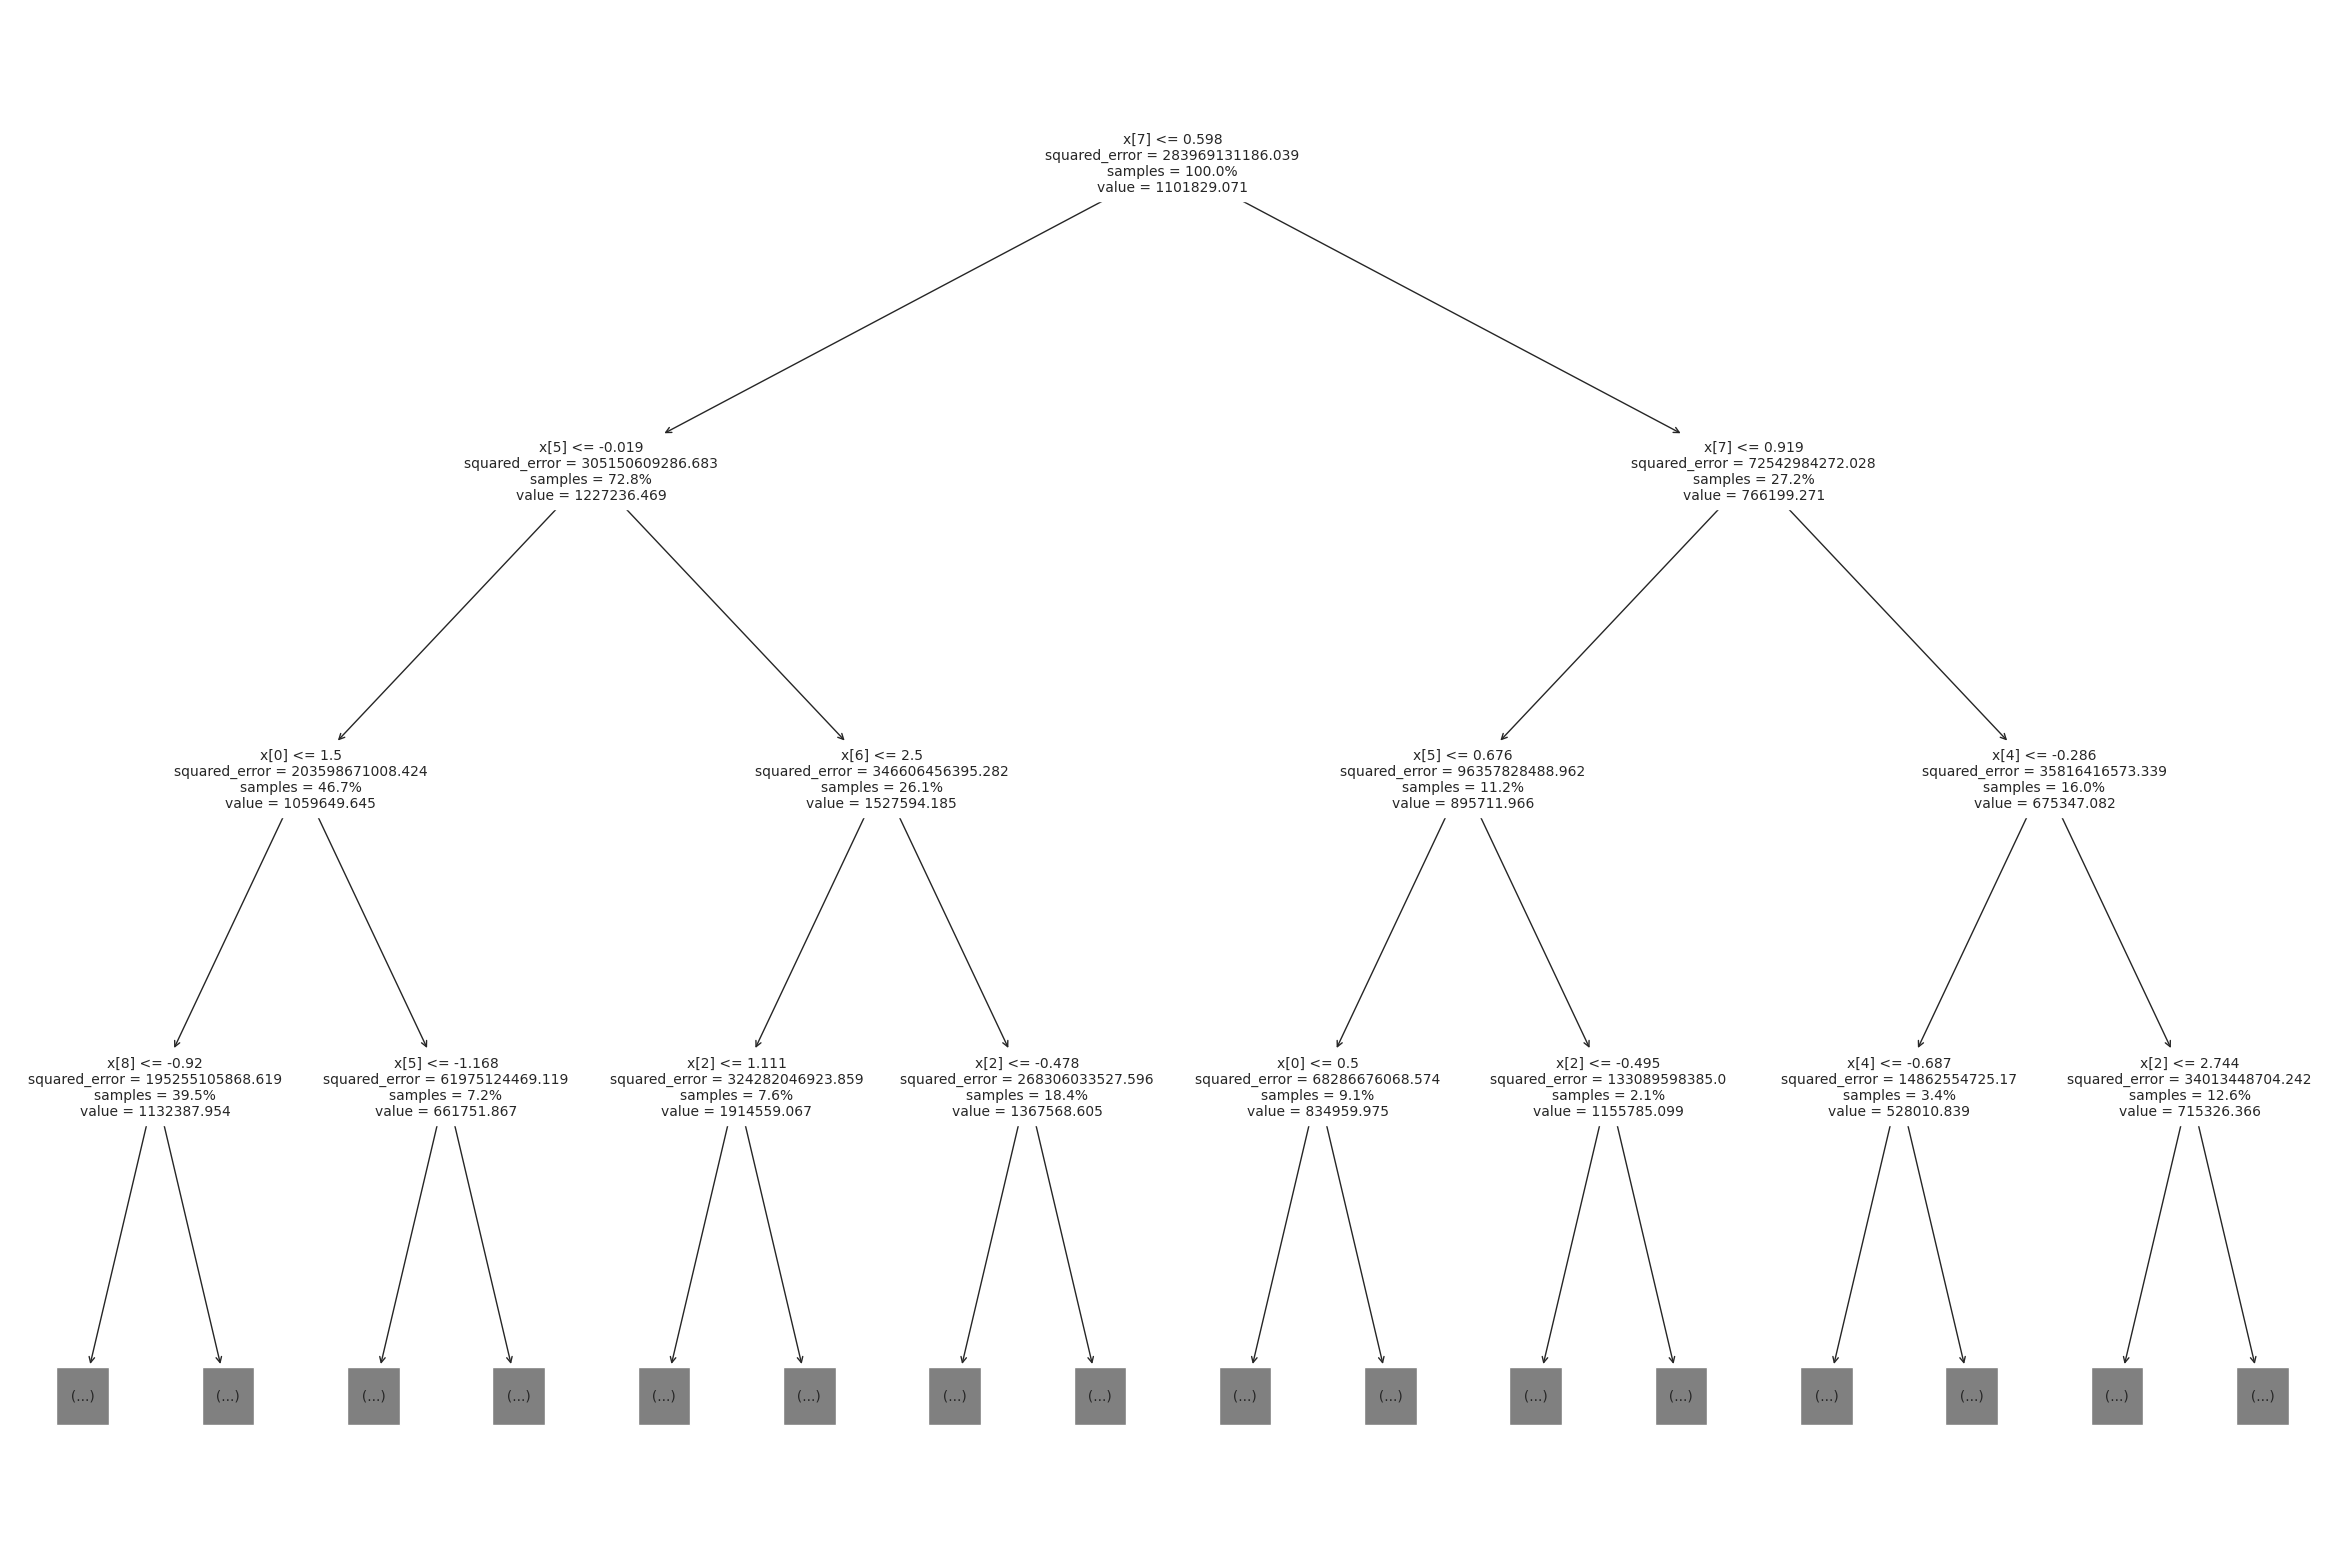

In [ ]:
fig,ax  = plt.subplots(figsize=(30,20))
plot_tree(model,ax=ax,fontsize=10,proportion=True,max_depth=3)

In [ ]:
rfpredict_tune=model.predict(X_test)

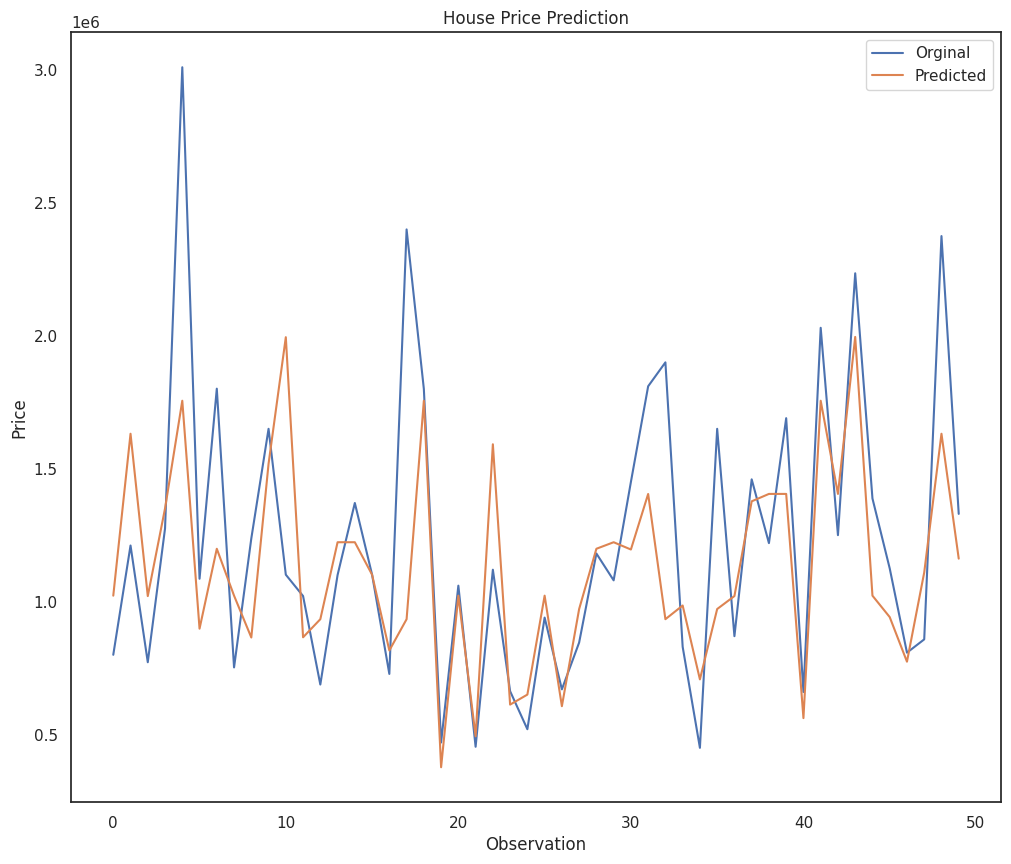

In [ ]:
# Visualization of prediction success
plt.figure(figsize=(12,10))
plt.plot(range(len(y_test[:50])),y_test[:50],label="Orginal")
plt.plot(range(len(rfpredict_tune[:50])),rfpredict_tune[:50],label="Predicted")
plt.title("House Price Prediction")
plt.xlabel("Observation")
plt.ylabel("Price")
plt.legend()
plt.show()

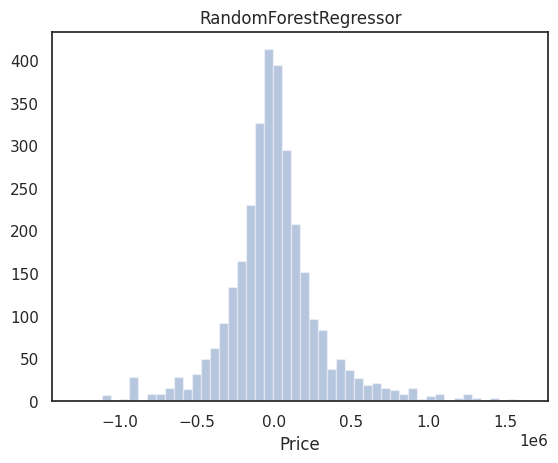

In [ ]:
# Distribution of errors
sns.distplot((y_test - rfpredict_tune),kde=False)
plt.title("RandomForestRegressor")
plt.show()

Errors appear to be normally distributed